In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
wavelet_data = '../../Data/Training/wavelet_pickle_data'
sensors = list(range(1,6))

# Load Full data

In [3]:
# Main folders
folder_2022 = f'{wavelet_data}/2022'
scaled_2022 = f'{folder_2022}/Scaled'

# 2022 Folder
X_test_scaled_2022_folder = f'{scaled_2022}/X_test_scaled.pkl'
X_test_2022_folder = f'{folder_2022}/X_test.pkl'
y_test_2022_folder = f'{folder_2022}/y_test.pkl'

# 2022 data
X_test_scaled_2022 = pd.read_pickle(open(X_test_scaled_2022_folder, 'rb'))
X_test_2022 = pd.read_pickle(open(X_test_2022_folder, 'rb'))
y_test_2022 = pd.read_pickle(open(y_test_2022_folder, 'rb'))

# 2023 folders
test_scaled_2023_folder = f'{wavelet_data}/2023/Scaled/test_scaled.pkl'
test_2023_folder = f'{wavelet_data}/2023/test.pkl'

# 2023 data
test_scaled_2023 = pd.read_pickle(open(test_scaled_2023_folder, 'rb'))
test_2023 = pd.read_pickle(open(test_2023_folder, 'rb'))

# Load sensor data

In [4]:
sensor_data = dict()

# Main folders
folder_2022_sensors = f'{wavelet_data}/2022_sensors'
scaled_2022_sensors = f'{folder_2022_sensors}/Scaled'

for sensor in sensors:
    # 2022 sensors folder
    X_test_scaled_2022_sensor_folder = f'{scaled_2022_sensors}/X_test_scaled_sensor_{sensor}.pkl'
    X_test_2022_sensor_folder = f'{folder_2022_sensors}/X_test_sensor_{sensor}.pkl'
    y_test_2022_sensor_folder = f'{folder_2022_sensors}/y_test_sensor_{sensor}.pkl'

    # 2022 sensors data
    X_test_scaled_2022_sensor = pd.read_pickle(open(X_test_scaled_2022_sensor_folder, 'rb'))
    X_test_2022_sensor = pd.read_pickle(open(X_test_2022_sensor_folder, 'rb'))
    y_test_2022_sensor = pd.read_pickle(open(y_test_2022_sensor_folder, 'rb'))

    # 2023 sensors folders
    test_scaled_2023_sensor_folder = f'{wavelet_data}/2023_sensors/Scaled/test_scaled_sensor_{sensor}.pkl'
    test_2023_sensor_folder = f'{wavelet_data}/2023_sensors/test_sensor_{sensor}.pkl'

    # 2023 sensors data
    test_scaled_2023_sensor = pd.read_pickle(open(test_scaled_2023_sensor_folder, 'rb'))
    test_2023_sensor = pd.read_pickle(open(test_2023_sensor_folder, 'rb'))

    sensor_data[f'sensor_{sensor}'] = {
        "X_test_scaled": X_test_scaled_2022_sensor,
        "X_test": X_test_2022_sensor,
        "y_test": y_test_2022_sensor,
        "test_scaled_2023": test_scaled_2023_sensor,
        "test_2023": test_2023_sensor
    }

# Get results

### Result helper functions and variables

In [5]:
# Columns for full data training
removable_full_columns = ['Redox_error_flag', 'pit_number', 'TIMESTAMP']
top_10_features = ['Wave_period_1.5(5)', 'Wave_period_1.9(5)', 'Wave_period_2.5(5)', 'Redox_Avg(2)_sigma_f_24', 'Redox_Avg(3)_sigma_b_24',
                   'Redox_Avg(3)_sigma_f_24', 'Redox_Avg(4)_sigma_b_24', 'Redox_Avg(4)_sigma_f_24', 'Redox_Avg(5)_sigma_b_24', 'Redox_Avg(5)_sigma_f_24']
full_wavelet_columns = ['Wave_period_0.5(1)', 'Wave_period_0.7(1)', 'Wave_period_0.9(1)', 'Wave_period_1.1(1)', 'Wave_period_1.5(1)', 'Wave_period_1.9(1)', 'Wave_period_2.5(1)', 'Wave_period_3.3(1)', 'Wave_period_4.4(1)',
                        'Wave_period_0.5(2)', 'Wave_period_0.7(2)', 'Wave_period_0.9(2)', 'Wave_period_1.1(2)', 'Wave_period_1.5(2)', 'Wave_period_1.9(2)', 'Wave_period_2.5(2)', 'Wave_period_3.3(2)', 'Wave_period_4.4(2)',
                        'Wave_period_0.5(3)', 'Wave_period_0.7(3)', 'Wave_period_0.9(3)', 'Wave_period_1.1(3)', 'Wave_period_1.5(3)', 'Wave_period_1.9(3)', 'Wave_period_2.5(3)', 'Wave_period_3.3(3)', 'Wave_period_4.4(3)',
                        'Wave_period_0.5(4)', 'Wave_period_0.7(4)', 'Wave_period_0.9(4)', 'Wave_period_1.1(4)', 'Wave_period_1.5(4)', 'Wave_period_1.9(4)', 'Wave_period_2.5(4)', 'Wave_period_3.3(4)', 'Wave_period_4.4(4)',
                        'Wave_period_0.5(5)', 'Wave_period_0.7(5)', 'Wave_period_0.9(5)', 'Wave_period_1.1(5)', 'Wave_period_1.5(5)', 'Wave_period_1.9(5)', 'Wave_period_2.5(5)', 'Wave_period_3.3(5)', 'Wave_period_4.4(5)']

# Columns for sensor data training
def get_removable_sensor_columns(sensor):
    return [f'Redox_error_flag({sensor})', 'Redox_error_flag', 'pit_number', 'TIMESTAMP']

top_10_sensor_features = {
    "sensor_1": ['Water_level_Avg', 'Redox_Avg(1)_sigma_b_24', 'Redox_Avg(1)_sigma_f_24', 'Redox_Avg(1)_sigma_f_12', 'Wave_period_0.5(1)',
                 'Wave_period_0.7(1)', 'Wave_period_0.9(1)', 'Wave_period_1.1(1)', 'Wave_period_1.5(1)', 'Wave_period_1.9(1)'],
    "sensor_2": ['Redox_Avg(2)', 'Redox_Avg(2)_sigma_b_24', 'Redox_Avg(2)_sigma_f_24', 'Redox_Avg(2)_sigma_b_12', 'Redox_Avg(2)_sigma_f_12',
                 'Wave_period_0.5(2)', 'Wave_period_0.7(2)', 'Wave_period_0.9(2)', 'Wave_period_1.1(2)', 'Wave_period_1.5(2)'],
    "sensor_3": ['Redox_Avg(3)_sigma_b_24', 'Redox_Avg(3)_sigma_f_24', 'Redox_Avg(3)_sigma_b_12', 'Redox_Avg(3)_sigma_f_12', 'Wave_period_0.5(3)',
                 'Wave_period_0.7(3)', 'Wave_period_0.9(3)', 'Wave_period_1.1(3)', 'Wave_period_1.5(3)', 'Wave_period_1.9(3)'],
    "sensor_4": ['Redox_Avg(4)_sigma_b_24', 'Redox_Avg(4)_sigma_f_24', 'Redox_Avg(4)_sigma_b_12', 'Redox_Avg(4)_sigma_f_12', 'Wave_period_0.7(4)',
                 'Wave_period_0.9(4)', 'Wave_period_1.1(4)', 'Wave_period_1.5(4)', 'Wave_period_1.9(4)', 'Wave_period_2.5(4)'],
    "sensor_5": ['Redox_Avg(5)_sigma_b_24', 'Redox_Avg(5)_sigma_f_24', 'Redox_Avg(5)_sigma_b_12', 'Redox_Avg(5)_sigma_f_12', 'Wave_period_0.7(5)',
                 'Wave_period_0.9(5)', 'Wave_period_1.1(5)', 'Wave_period_1.5(5)', 'Wave_period_1.9(5)', 'Wave_period_2.5(5)']
}

def get_results_df(test_X, test_y, pred, sensor=0):
    result = test_X.copy()
    result['pred'] = pred
    if sensor > 0:
        result[f'Redox_error_flag({sensor})'] = test_y[f'Redox_error_flag({sensor})']
        result['true_pos'] = np.where((result[f'Redox_error_flag({sensor})']==True) & (result['pred']==True), True, False)
        result['false_pos'] = np.where((result[f'Redox_error_flag({sensor})']==False) & (result['pred']==True), True, False)
        result['false_neg'] = np.where((result[f'Redox_error_flag({sensor})']==True) & (result['pred']==False), True, False)
    else:
        result['Redox_error_flag'] = test_y['Redox_error_flag']
        result['true_pos'] = np.where((result['Redox_error_flag']==True) & (result['pred']==True), True, False)
        result['false_pos'] = np.where((result['Redox_error_flag']==False) & (result['pred']==True), True, False)
        result['false_neg'] = np.where((result['Redox_error_flag']==True) & (result['pred']==False), True, False)
    result = result.sort_index()
    return result

def get_results_df_2023(test_data, pred):
    result = test_data.copy()
    result['pred'] = pred
    result = result.sort_index()
    return result

## Load models

In [6]:
model_folder = './models'

# 2022 all columns
svc_2022_full_file_name = f'{model_folder}/svc_2022_full.pkl'
svc_2022_full = pickle.load(open(svc_2022_full_file_name, 'rb'))
# 2022 top 10 columns
svc_2022_fs_file_name = f'{model_folder}/svc_2022_fs.pkl'
svc_2022_fs = pickle.load(open(svc_2022_fs_file_name, 'rb'))
# 2022 wavelet columns
svc_2022_wavelet_file_name = f'{model_folder}/svc_2022_wavelet.pkl'
svc_2022_wavelet = pickle.load(open(svc_2022_wavelet_file_name, 'rb'))

# Sensor models
sensor_models = dict()

for sensor in sensors:
    # 2022 sensor all columns
    svc_sensor_file_name = f'{model_folder}/svc_sensor_{sensor}.pkl'
    svc_sensor = pickle.load(open(svc_sensor_file_name, 'rb'))
    sensor_models[f'svc_sensor_{sensor}'] = svc_sensor

    # 2022 sensor top 10 columns
    svc_fs_sensor_file_name = f'{model_folder}/svc_fs_sensor_{sensor}.pkl'
    svc_fs_sensor = pickle.load(open(svc_fs_sensor_file_name, 'rb'))
    sensor_models[f'svc_fs_sensor_{sensor}'] = svc_fs_sensor

In [7]:
# 2022 model results with all columns
predictions_2022_full = svc_2022_full.predict(X_test_scaled_2022.loc[:, ~X_test_scaled_2022.columns.isin(removable_full_columns)])
predictions_2023_full = svc_2022_full.predict(test_scaled_2023.loc[:, ~test_scaled_2023.columns.isin(removable_full_columns)])
cm_2022_full = confusion_matrix(y_test_2022['Redox_error_flag'], predictions_2022_full)

# 2022 model results with feature selection
predictions_2022_fs = svc_2022_fs.predict(X_test_scaled_2022.loc[:, top_10_features])
predictions_2023_fs = svc_2022_fs.predict(test_scaled_2023.loc[:, top_10_features])
cm_2022_fs = confusion_matrix(y_test_2022['Redox_error_flag'], predictions_2022_fs)

# 2022 model results with wavelet columns
predictions_2022_wavelet = svc_2022_wavelet.predict(X_test_scaled_2022.loc[:, full_wavelet_columns])
predictions_2023_wavelet = svc_2022_wavelet.predict(test_scaled_2023.loc[:, full_wavelet_columns])
cm_2022_wavelet = confusion_matrix(y_test_2022['Redox_error_flag'], predictions_2022_wavelet)

In [8]:
sensor_predictions = dict()
sensor_cm = dict()

# 2022 sensor model results
for sensor in sensors:
    scaled_testing_data = sensor_data[f'sensor_{sensor}']['X_test_scaled']
    scaled_testing_data_2023 = sensor_data[f'sensor_{sensor}']['test_scaled_2023']
    true_y = sensor_data[f'sensor_{sensor}']['y_test']

    # All columns
    removable_sensors_columns = get_removable_sensor_columns(sensor)
    sensor_predictions[f'sensor_{sensor}_2022'] = sensor_models[f'svc_sensor_{sensor}'].predict(scaled_testing_data.loc[:, ~scaled_testing_data.columns.isin(removable_sensors_columns)])
    sensor_predictions[f'sensor_{sensor}_2023'] = sensor_models[f'svc_sensor_{sensor}'].predict(scaled_testing_data_2023.loc[:, ~scaled_testing_data_2023.columns.isin(removable_sensors_columns)])
    sensor_cm[f'sensor_{sensor}_2022'] = confusion_matrix(true_y[f'Redox_error_flag({sensor})'], sensor_predictions[f'sensor_{sensor}_2022'])

    # Feature selection
    fs_columns = top_10_sensor_features[f'sensor_{sensor}']
    sensor_predictions[f'sensor_{sensor}_2022_fs'] = sensor_models[f'svc_fs_sensor_{sensor}'].predict(scaled_testing_data.loc[:, fs_columns])
    sensor_predictions[f'sensor_{sensor}_2023_fs'] = sensor_models[f'svc_fs_sensor_{sensor}'].predict(scaled_testing_data_2023.loc[:, fs_columns])
    sensor_cm[f'sensor_{sensor}_2022_fs'] = confusion_matrix(true_y[f'Redox_error_flag({sensor})'], sensor_predictions[f'sensor_{sensor}_2022_fs'])

# Print results

### Print functions

In [9]:
# Common print variables
ncols = 1
nrows = len(sensors)
opacity = 0.5
# plt.subplots_adjust(hspace=1.0)

def log_false_neg_and_pos_count(results):
    print('False positive (cyan) count: ', len(results.loc[results['false_pos']==True]))
    print('False negative (orange) count: ', len(results.loc[results['false_neg']==True]))

def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='g', 
            xticklabels=['Error','Not Error'],
            yticklabels=['Error','Not Error'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)

# Full data plot functions
def plot_results(results, title):
    plt.figure(figsize=(35,nrows*13))
    plt.suptitle(title, fontsize=36, y=0.95)

    log_false_neg_and_pos_count(results)

    for i, sensor in enumerate(sensors):
        i += 1
        ax = plt.subplot(nrows, ncols, i)
        ax.set_title(f'Predictions for sensor {sensor}', fontsize = 24)
        ax.plot(results.index.array, results[f'Redox_Avg({sensor})'], c='g', zorder=0)
        #plt.plot(plt_results_sens_1.index.array, plt_results_sens_1[f'Matric_potential_Avg({1})'], c='magenta', zorder=0)
        ax.scatter(results.loc[results[f'Redox_error_flag']==True].index.array, results.loc[results[f'Redox_error_flag']==True][f'Redox_Avg({sensor})'], c='r', s=35, zorder=5, alpha=opacity)
        ax.scatter(results.loc[results['true_pos']==True].index.array, results.loc[results['true_pos']==True][f'Redox_Avg({sensor})'], c='blue', s=15, zorder=10, alpha=opacity)
        ax.scatter(results.loc[results['false_pos']==True].index.array, results.loc[results['false_pos']==True][f'Redox_Avg({sensor})'], c='cyan', s=25, zorder=10, alpha=opacity)
        ax.scatter(results.loc[results['false_neg']==True].index.array, results.loc[results['false_neg']==True][f'Redox_Avg({sensor})'], c='orange', s=25, zorder=10, alpha=opacity)

def plot_results_2023(results, title):
    plt.figure(figsize=(35,nrows*13))
    plt.suptitle(title, fontsize=36, y=0.95)

    for i, sensor in enumerate(sensors):
        i += 1
        ax = plt.subplot(nrows, ncols, i)
        ax.set_title(f'Predictions for sensor {sensor}', fontsize = 24)
        ax.plot(results.index.array, results[f'Redox_Avg({sensor})'], c='g', zorder=0)
        ax.scatter(results.loc[results[f'pred']==True].index.array, results.loc[results[f'pred']==True][f'Redox_Avg({sensor})'], c='r', s=35, zorder=5, alpha=opacity)

# Sensor data plot functions
def plot_sensor_results(results, sensor, title):
    plt.figure(figsize=(35,13))
    plt.suptitle(title, fontsize=36, y=0.95)

    log_false_neg_and_pos_count(results)

    plt.plot(results.index.array, results[f'Redox_Avg({sensor})'], c='g', zorder=0)
    #plt.plot(plt_results_sens_1.index.array, plt_results_sens_1[f'Matric_potential_Avg({1})'], c='magenta', zorder=0)
    plt.scatter(results.loc[results[f'Redox_error_flag({sensor})']==True].index.array, results.loc[results[f'Redox_error_flag({sensor})']==True][f'Redox_Avg({sensor})'], c='r', s=35, zorder=5)
    plt.scatter(results.loc[results['true_pos']==True].index.array, results.loc[results['true_pos']==True][f'Redox_Avg({sensor})'], c='blue', s=15, zorder=10, alpha=opacity)
    plt.scatter(results.loc[results['false_pos']==True].index.array, results.loc[results['false_pos']==True][f'Redox_Avg({sensor})'], c='cyan', s=25, zorder=10, alpha=opacity)
    plt.scatter(results.loc[results['false_neg']==True].index.array, results.loc[results['false_neg']==True][f'Redox_Avg({sensor})'], c='orange', s=25, zorder=10, alpha=opacity)

def plot_2023_sensor_results(results, sensor, title):
    plt.figure(figsize=(35,13))
    plt.suptitle(title, fontsize=36, y=0.95)

    plt.plot(results.index.array, results[f'Redox_Avg({sensor})'], c='g', zorder=0)
    plt.scatter(results.loc[results[f'pred']==True].index.array, results.loc[results[f'pred']==True][f'Redox_Avg({sensor})'], c='r', s=35, zorder=5, alpha=opacity)

## 2022 full columns

False positive (cyan) count:  3
False negative (orange) count:  1


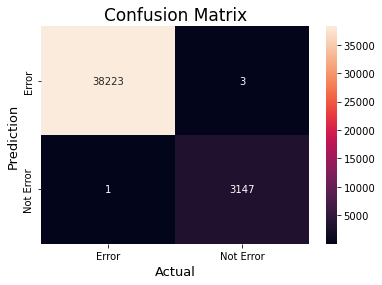

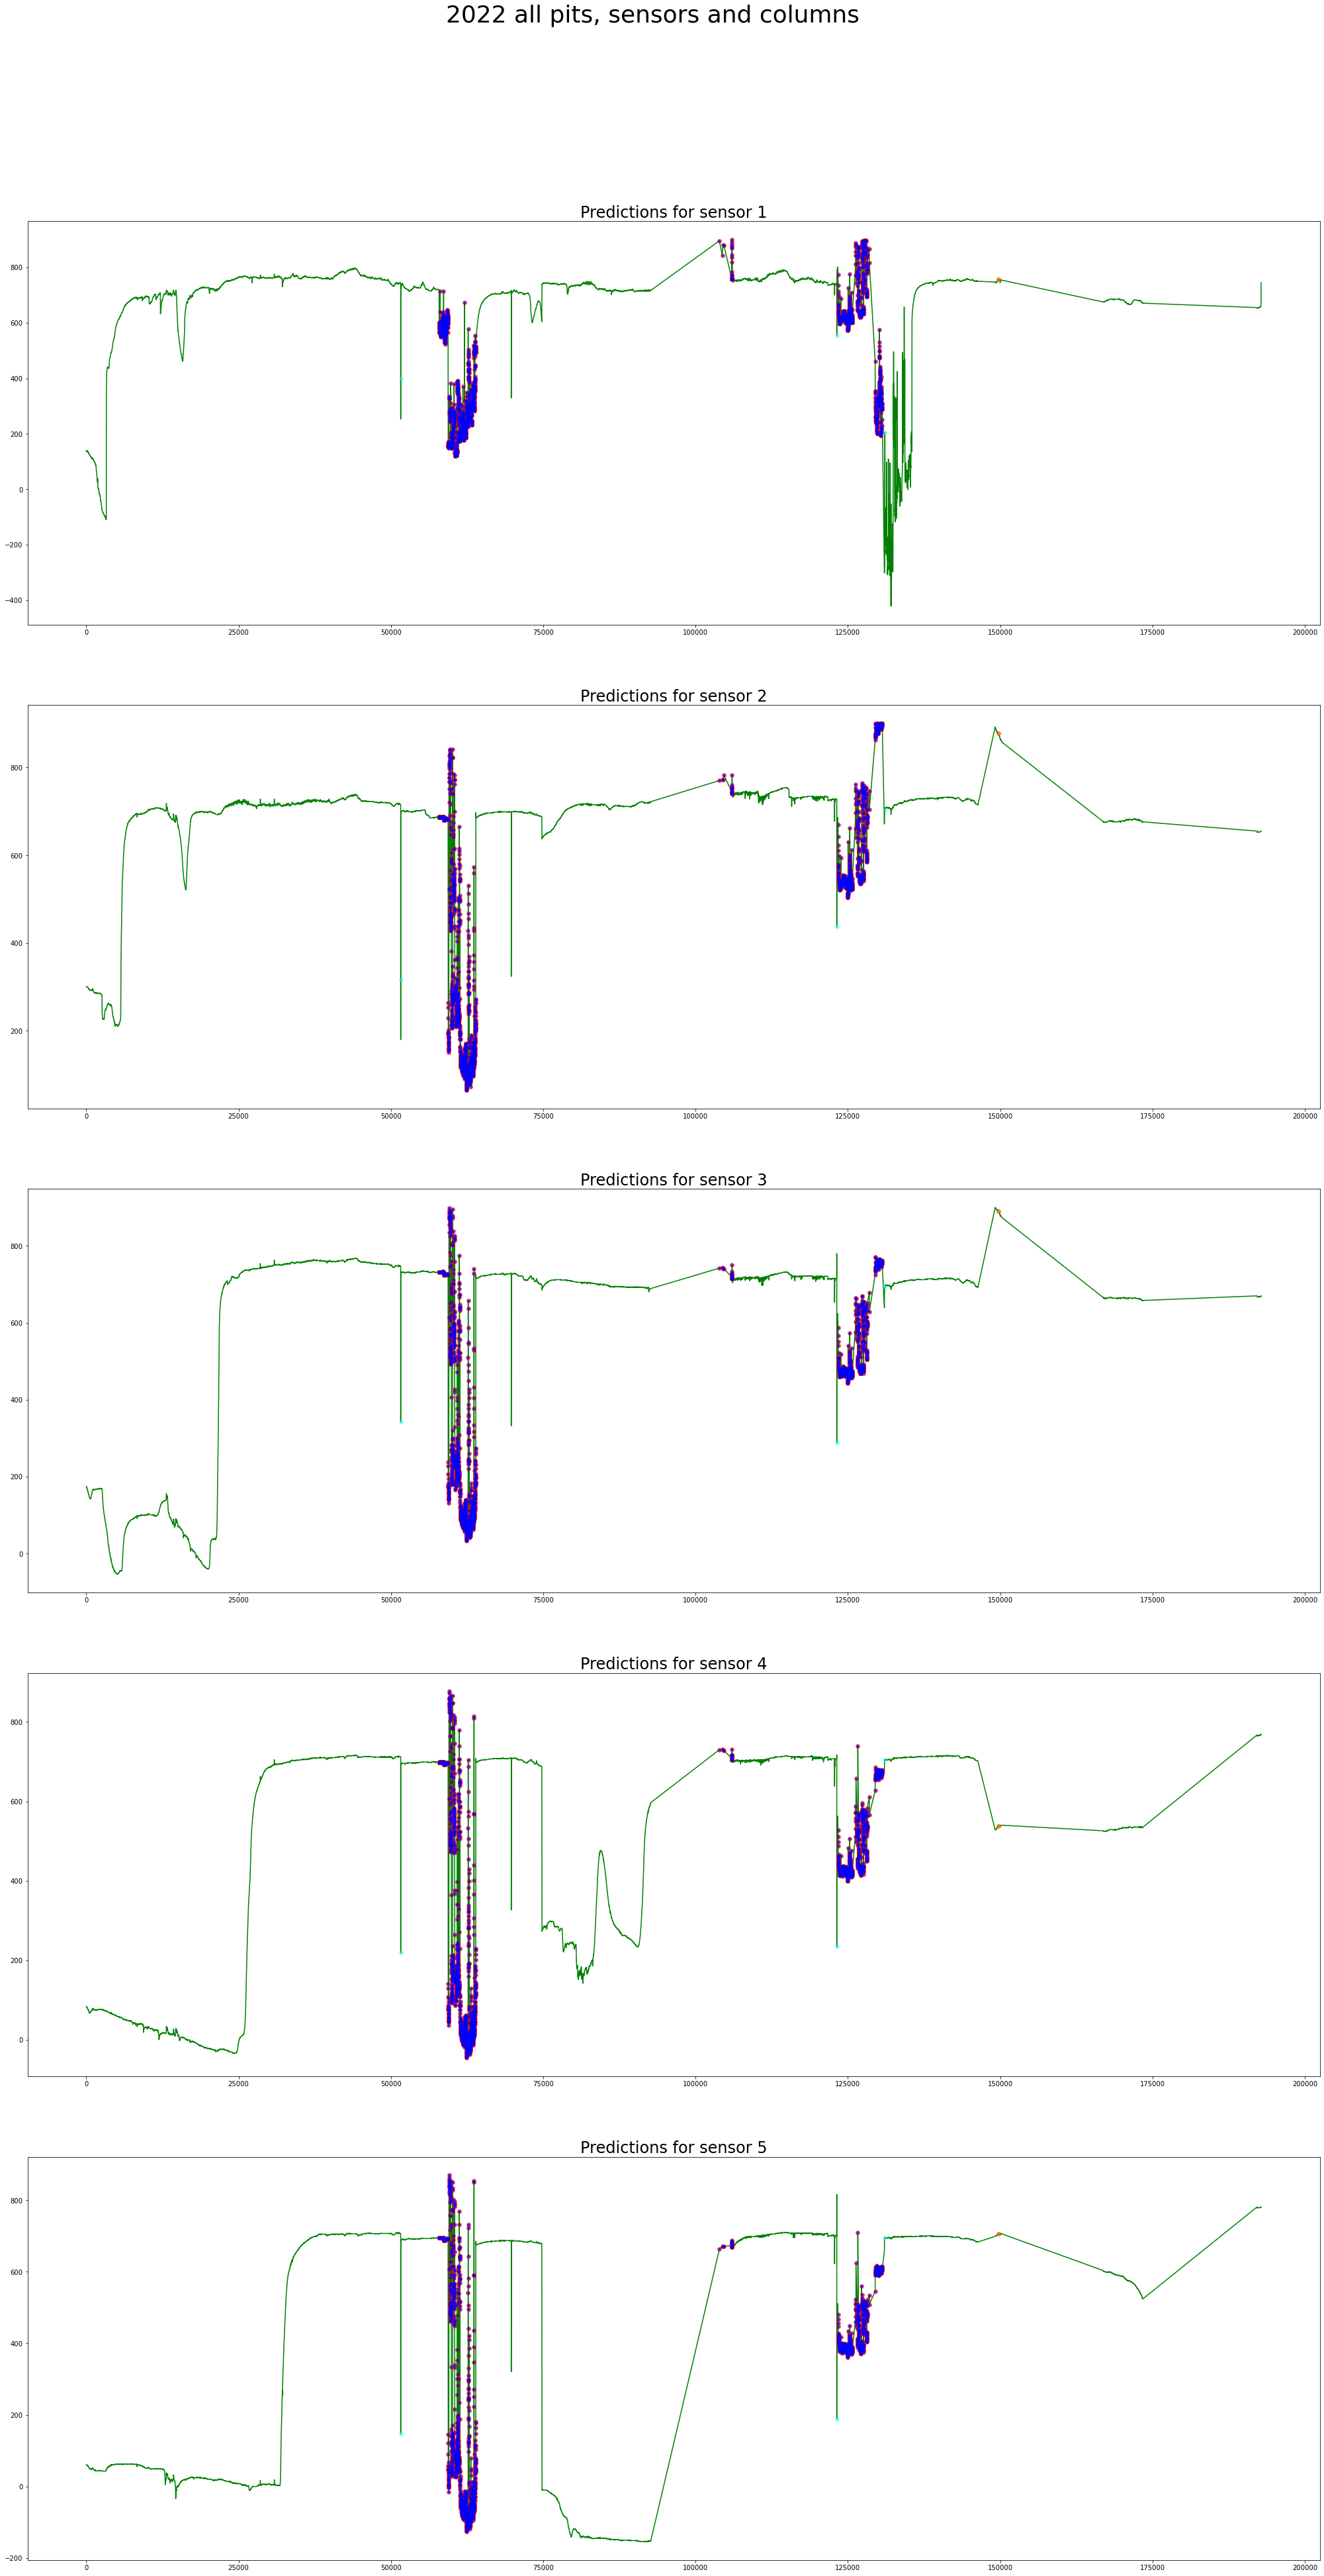

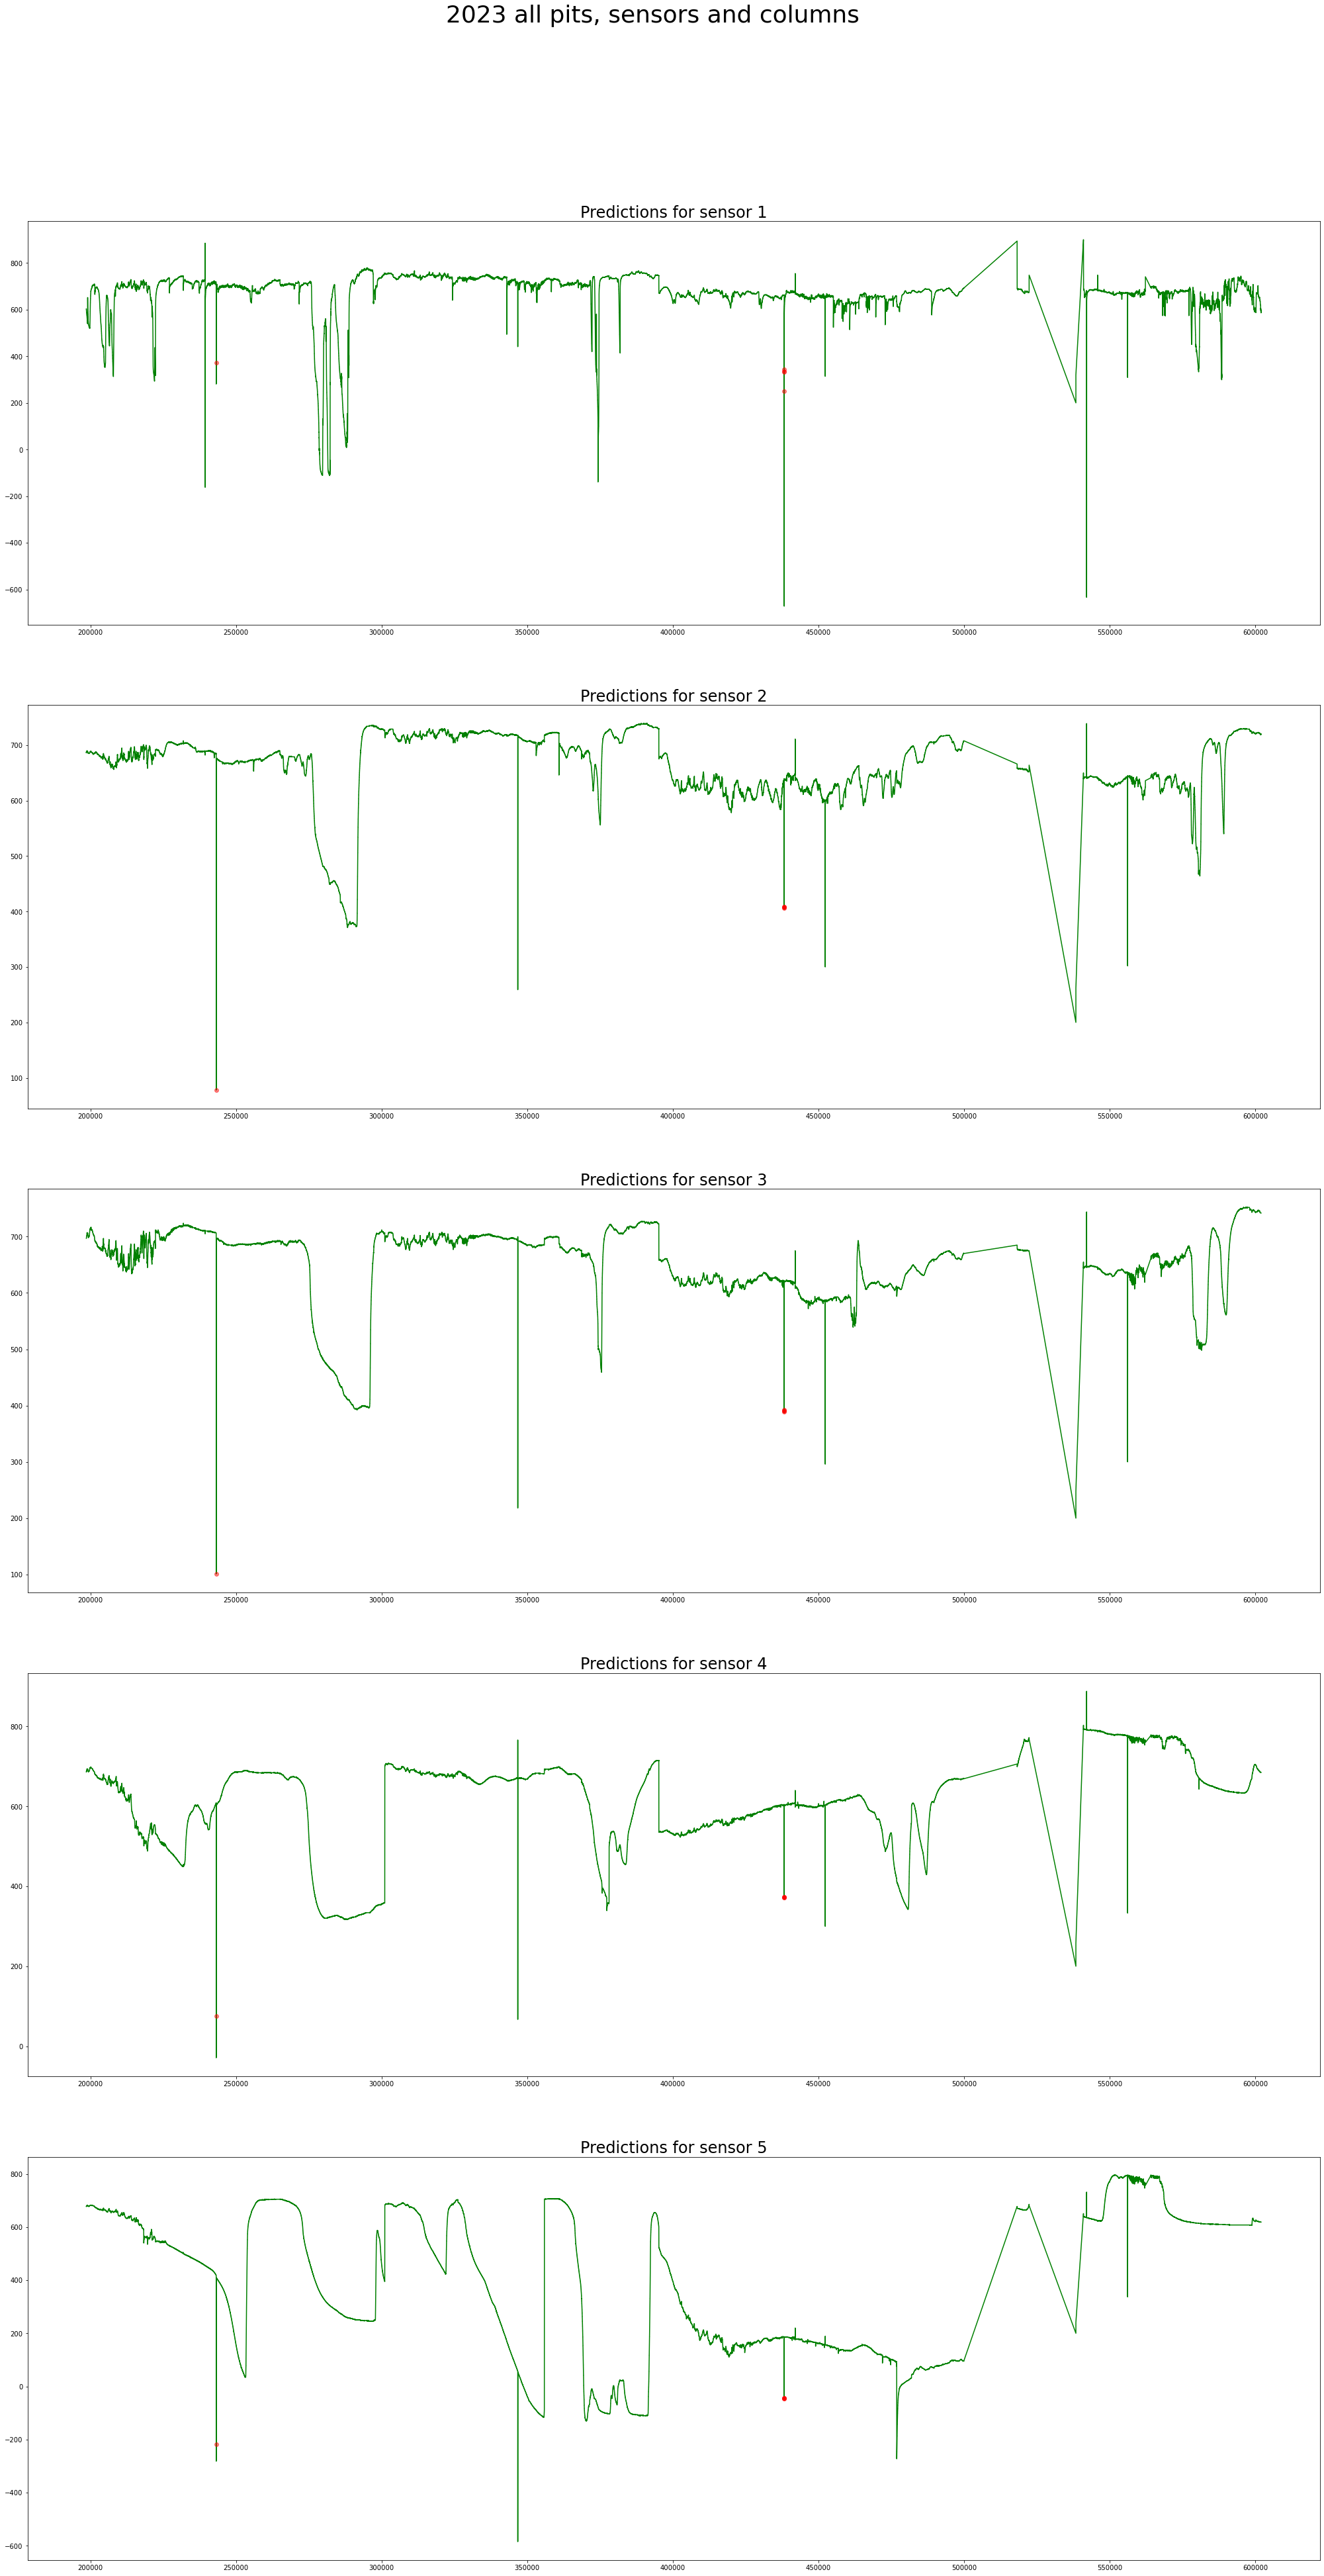

In [10]:
full_2022_results = get_results_df(X_test_2022, y_test_2022, predictions_2022_full)
full_2023_results = get_results_df_2023(test_2023, predictions_2023_full)

plot_confusion_matrix(cm_2022_full)
plot_results(full_2022_results, "2022 all pits, sensors and columns")
plot_results_2023(full_2023_results, "2023 all pits, sensors and columns")

## 2022 feature selection columns

False positive (cyan) count:  12
False negative (orange) count:  1212


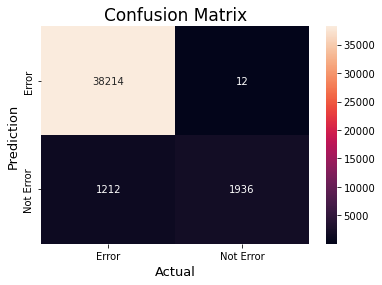

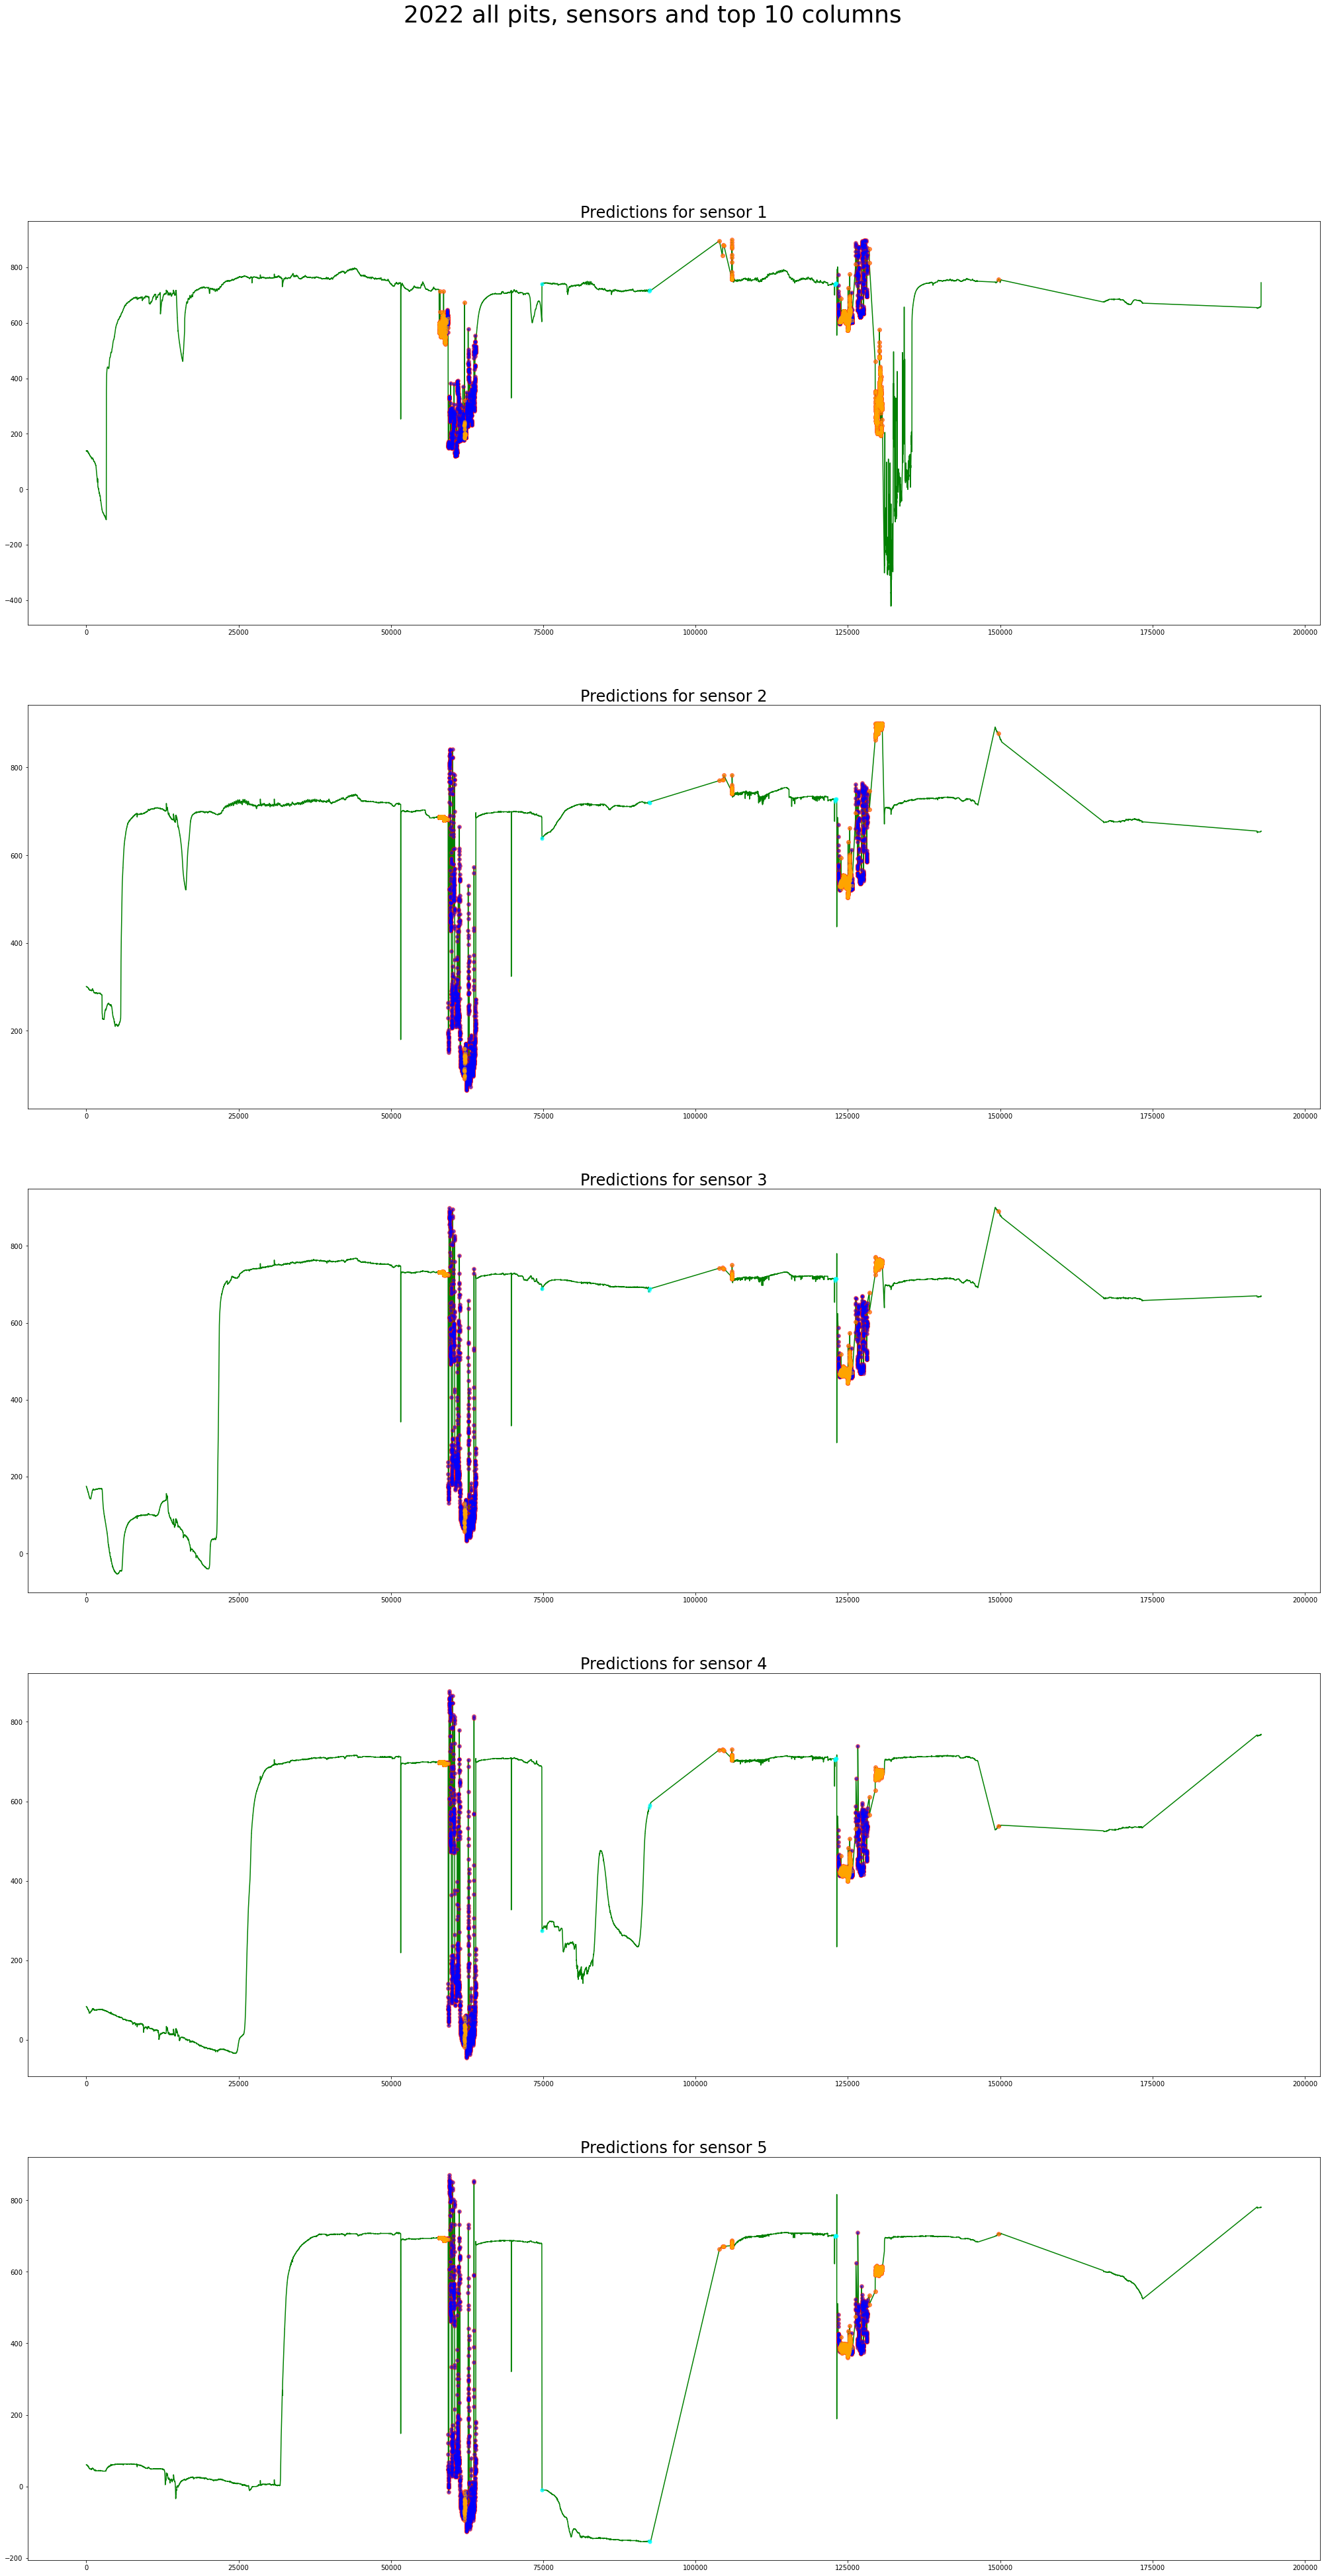

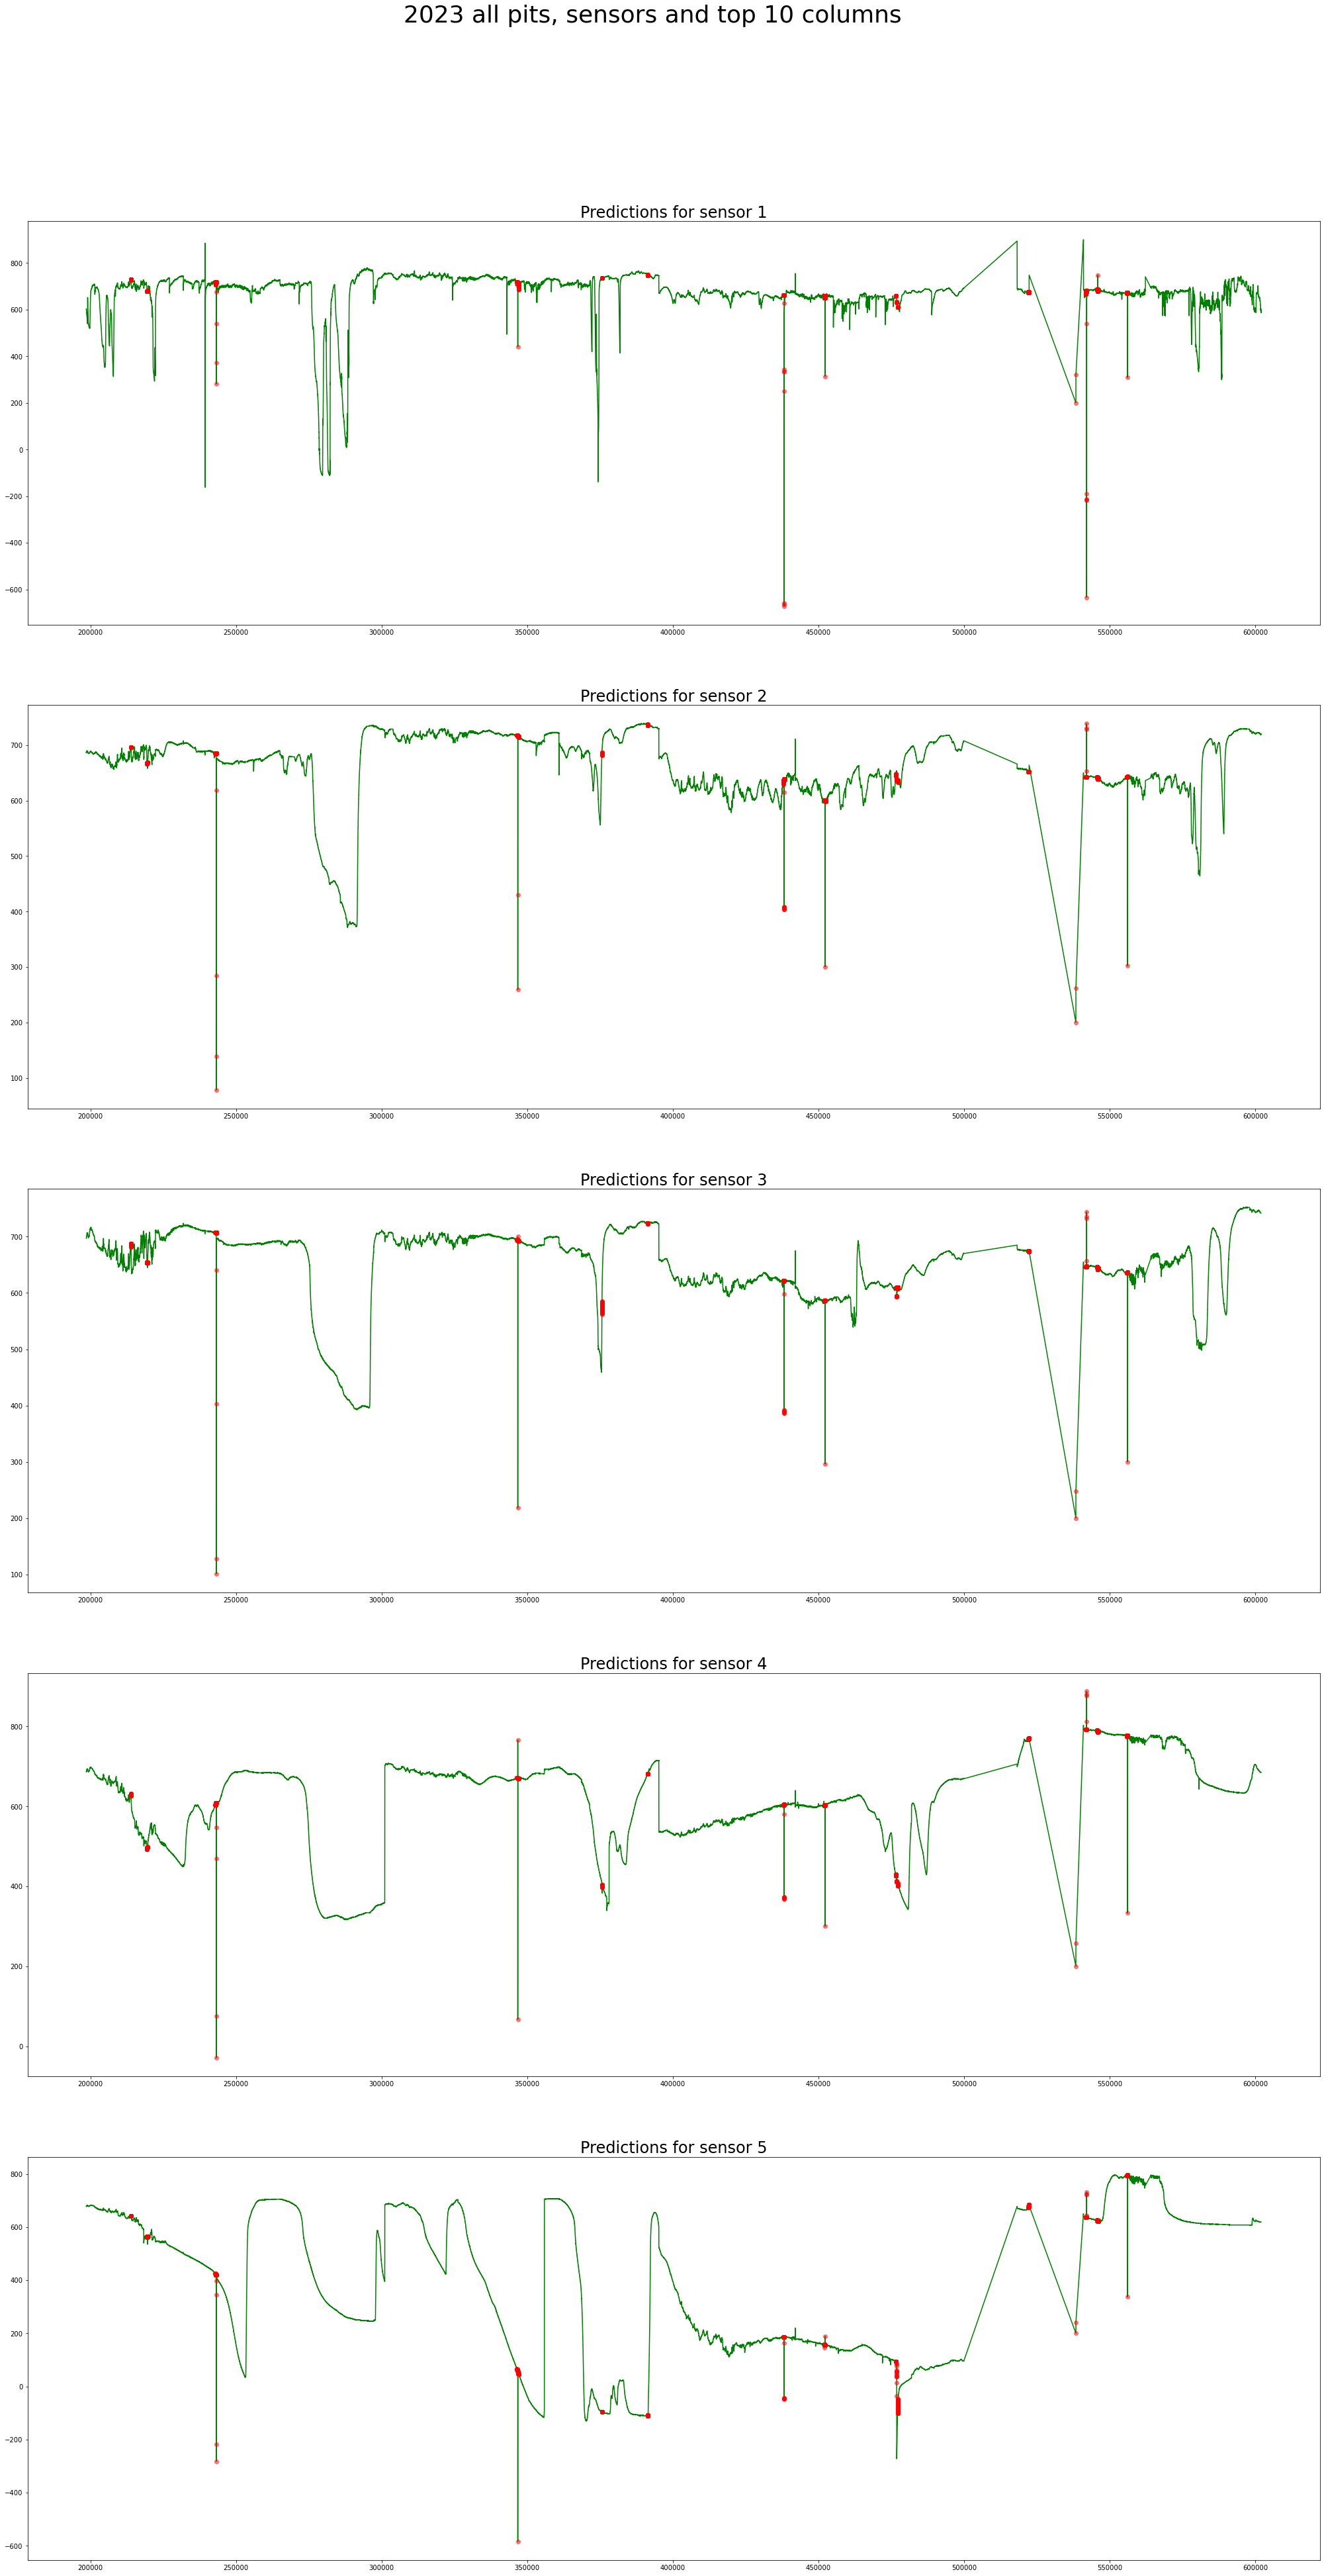

In [11]:
fs_2022_results = get_results_df(X_test_2022, y_test_2022, predictions_2022_fs)
fs_2023_results = get_results_df_2023(test_2023, predictions_2023_fs)

plot_confusion_matrix(cm_2022_fs)
plot_results(fs_2022_results, "2022 all pits, sensors and top 10 columns")
plot_results_2023(fs_2023_results, "2023 all pits, sensors and top 10 columns")

## 2022 wavelet columns

False positive (cyan) count:  45
False negative (orange) count:  306


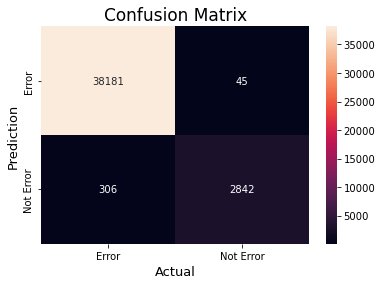

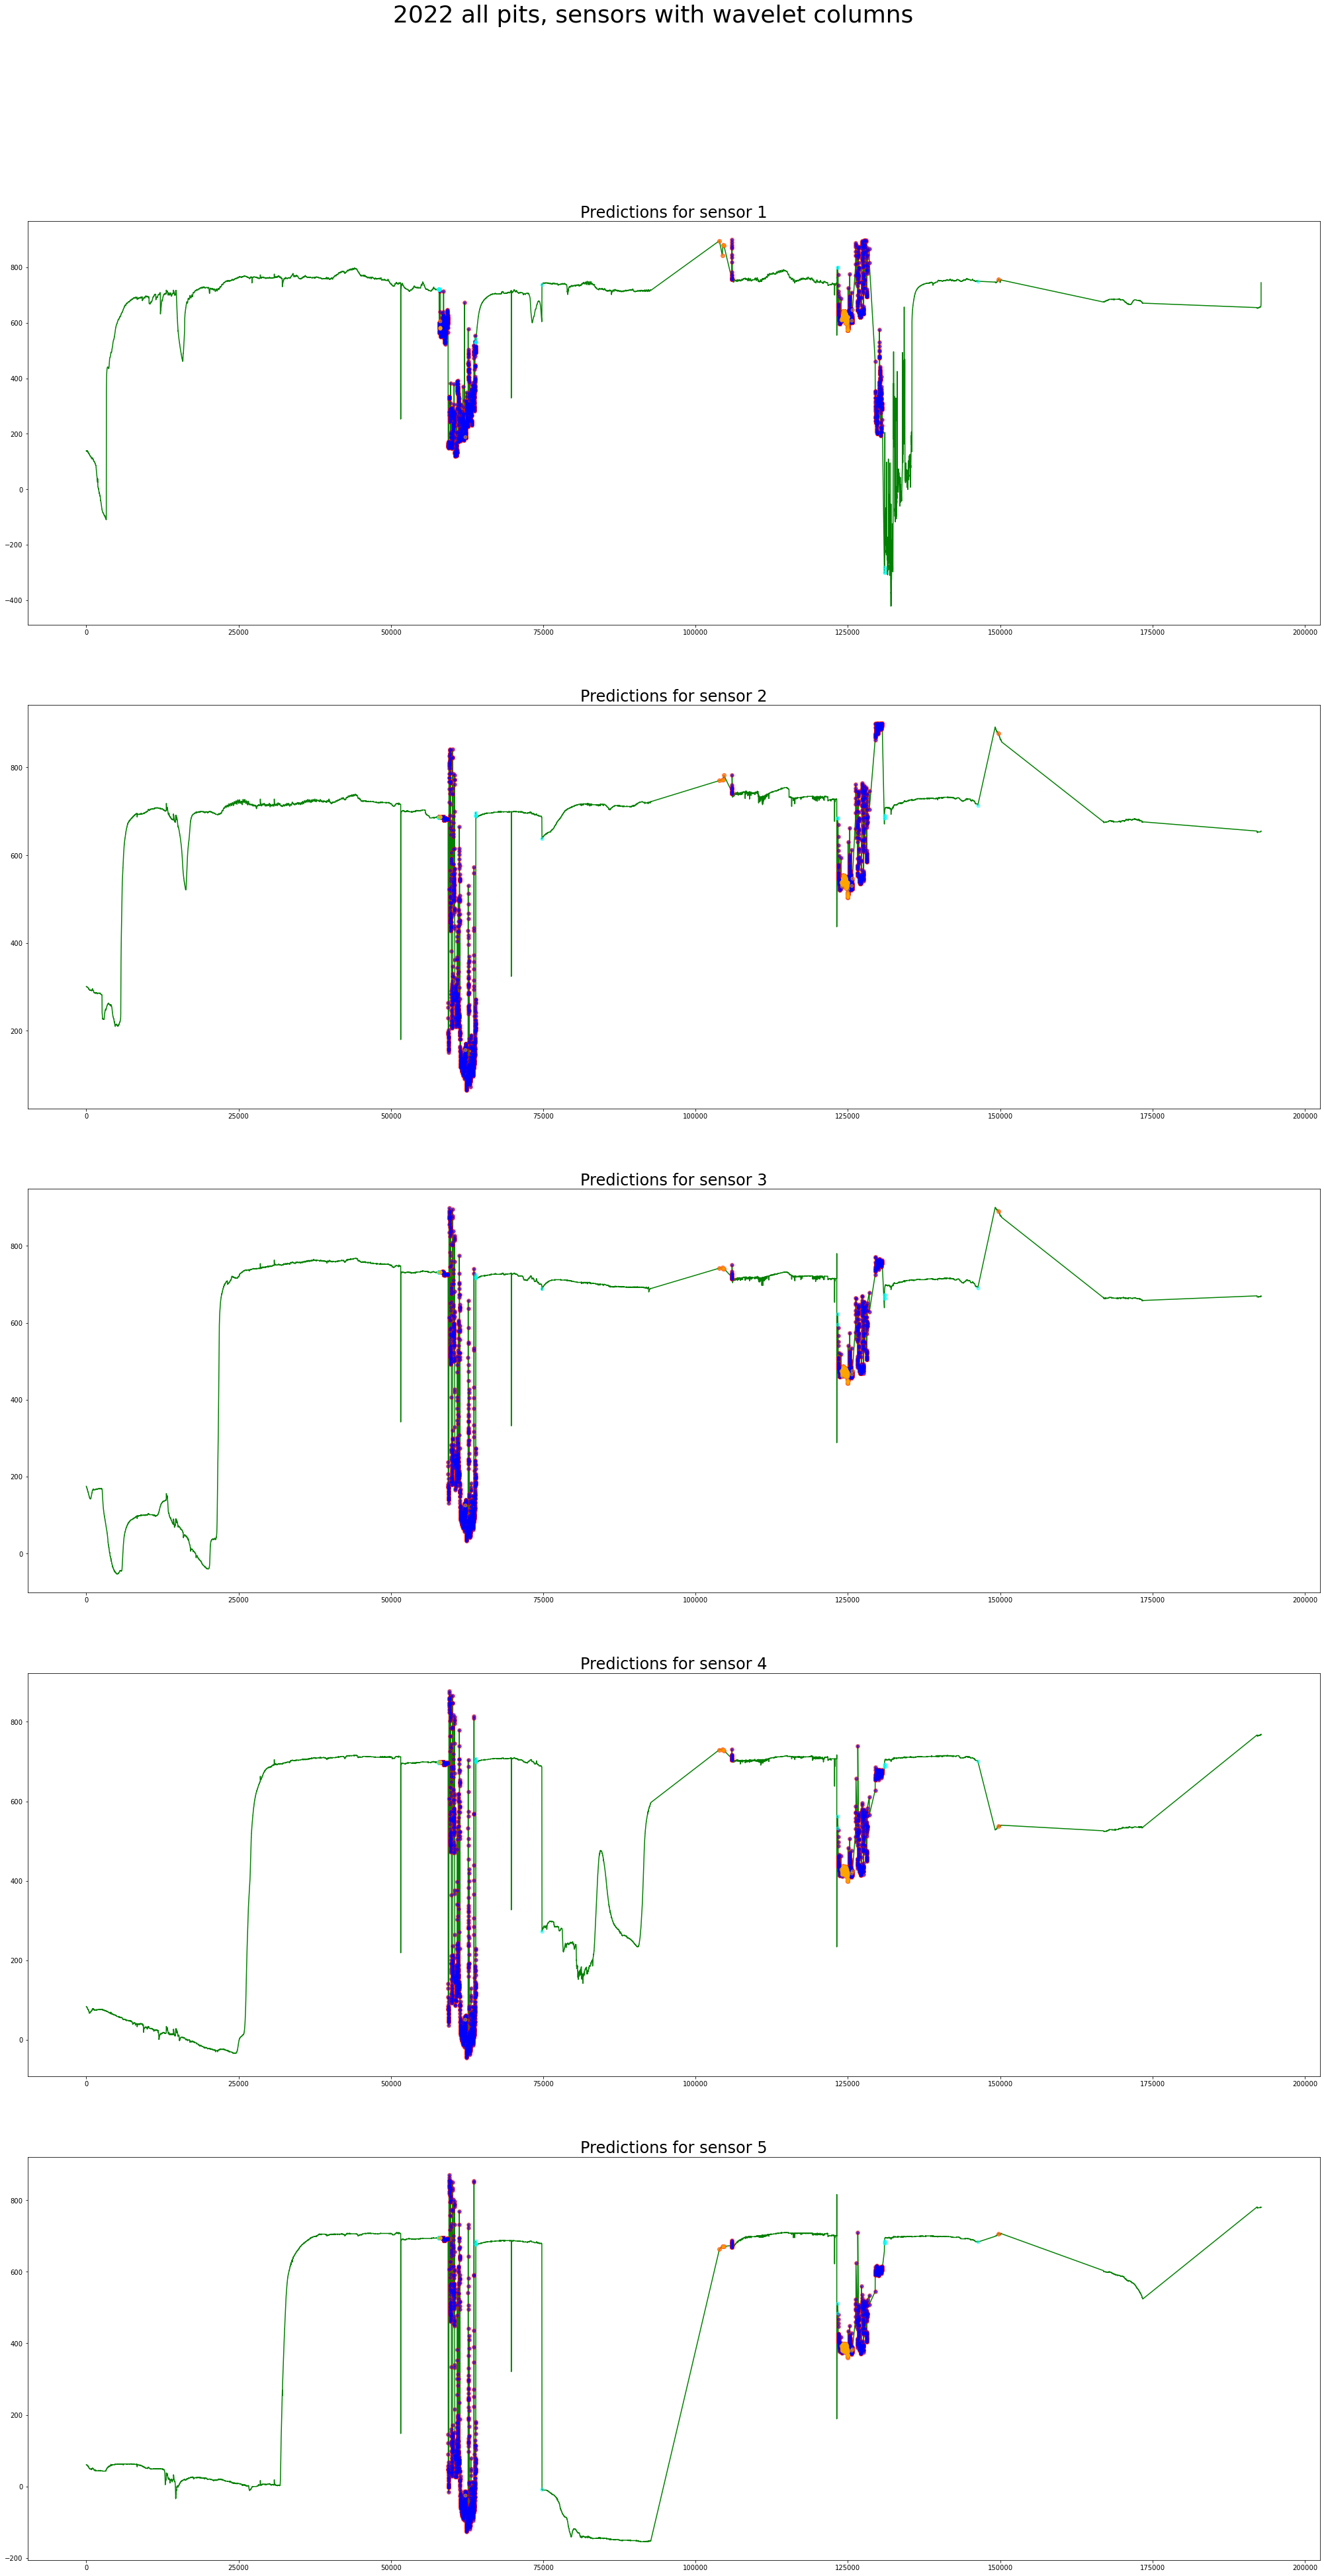

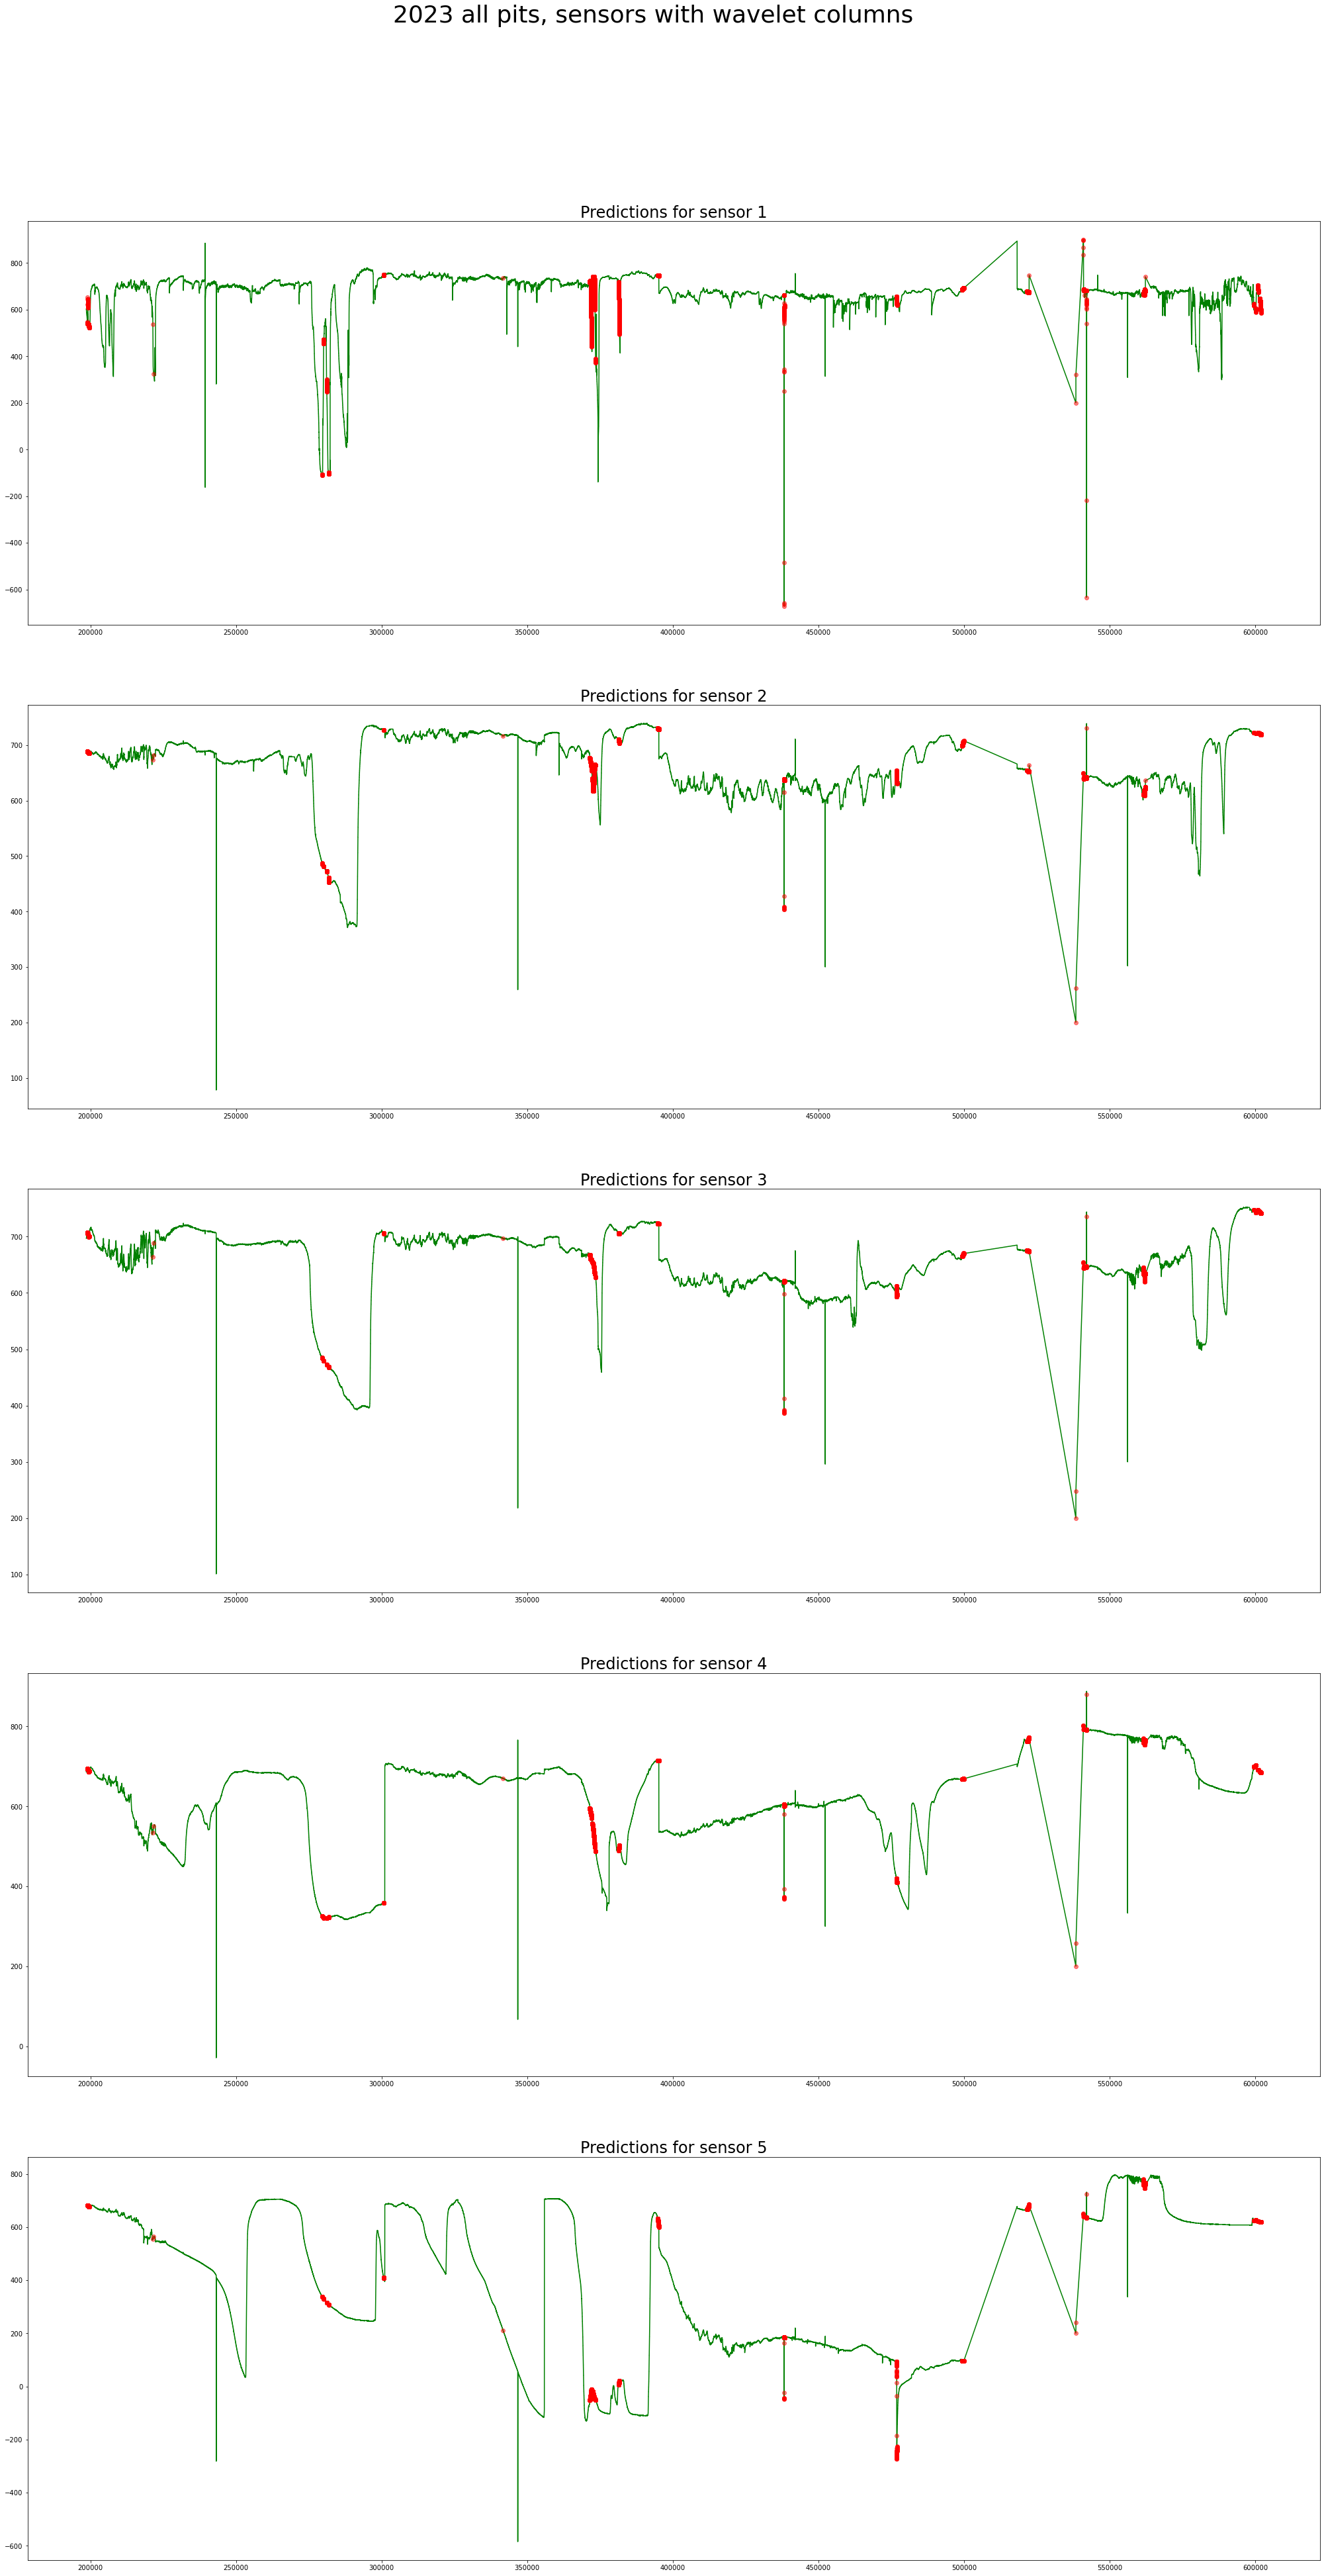

In [12]:
wavelet_2022_results = get_results_df(X_test_2022, y_test_2022, predictions_2022_wavelet)
wavelet_2023_results = get_results_df_2023(test_2023, predictions_2023_wavelet)

plot_confusion_matrix(cm_2022_wavelet)
plot_results(wavelet_2022_results, "2022 all pits, sensors with wavelet columns")
plot_results_2023(wavelet_2023_results, "2023 all pits, sensors with wavelet columns")

## 2022 sensor full columns

## Sensor 1

False positive (cyan) count:  1777
False negative (orange) count:  0


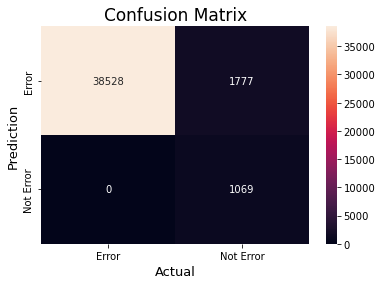

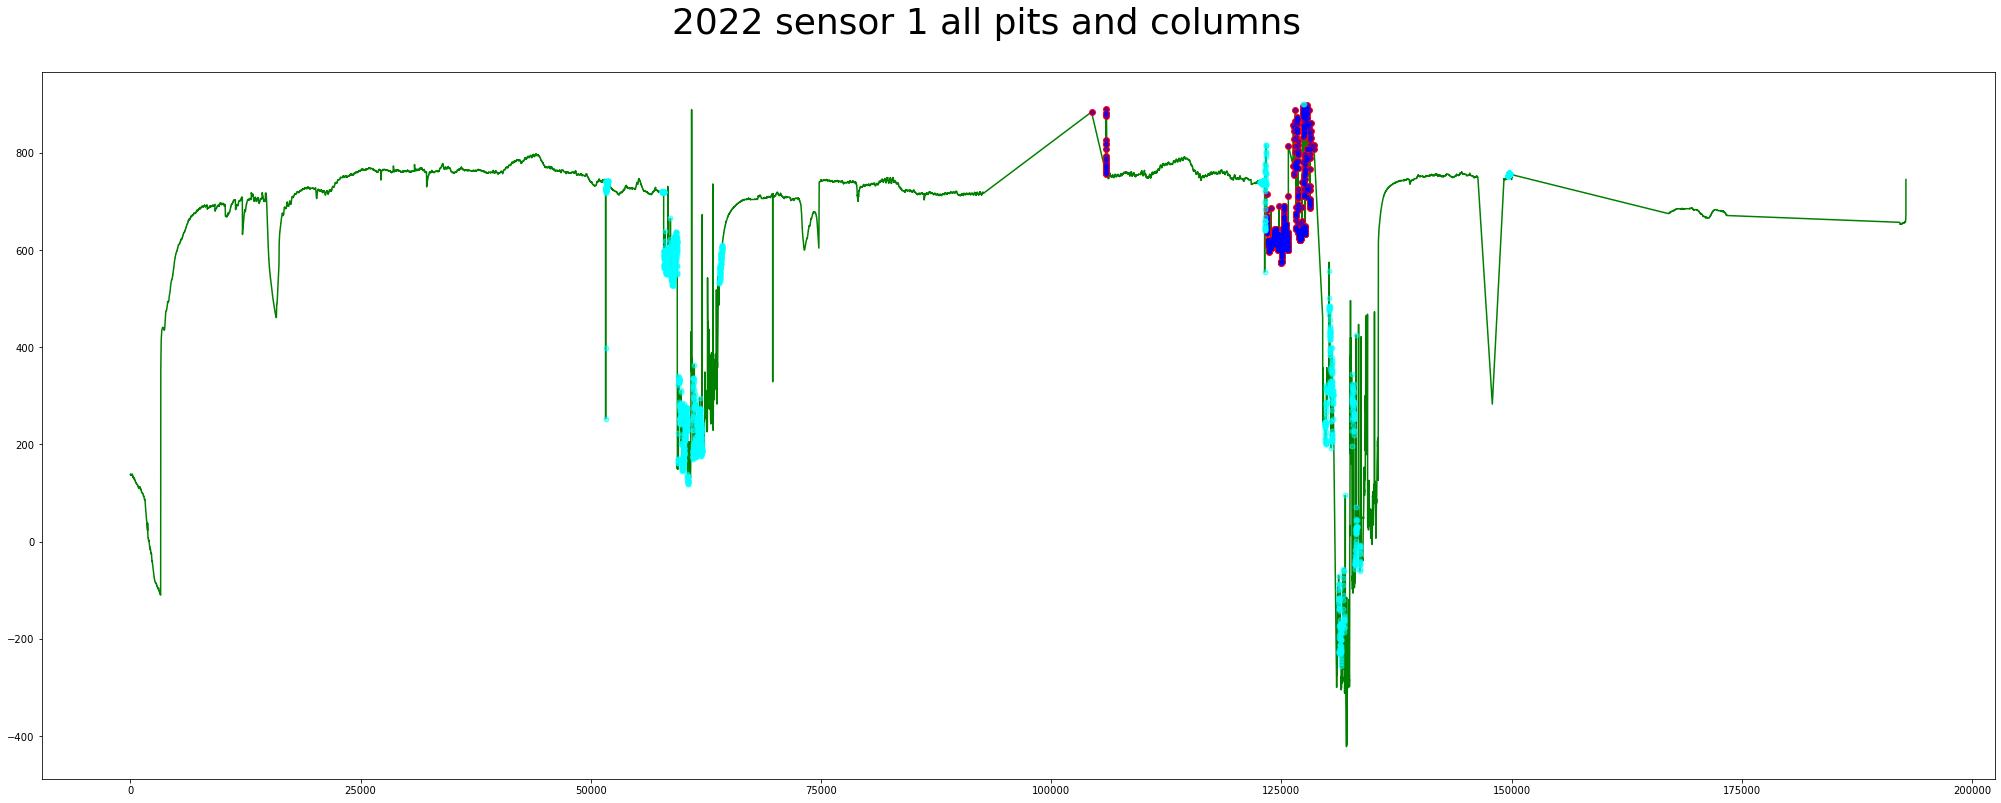

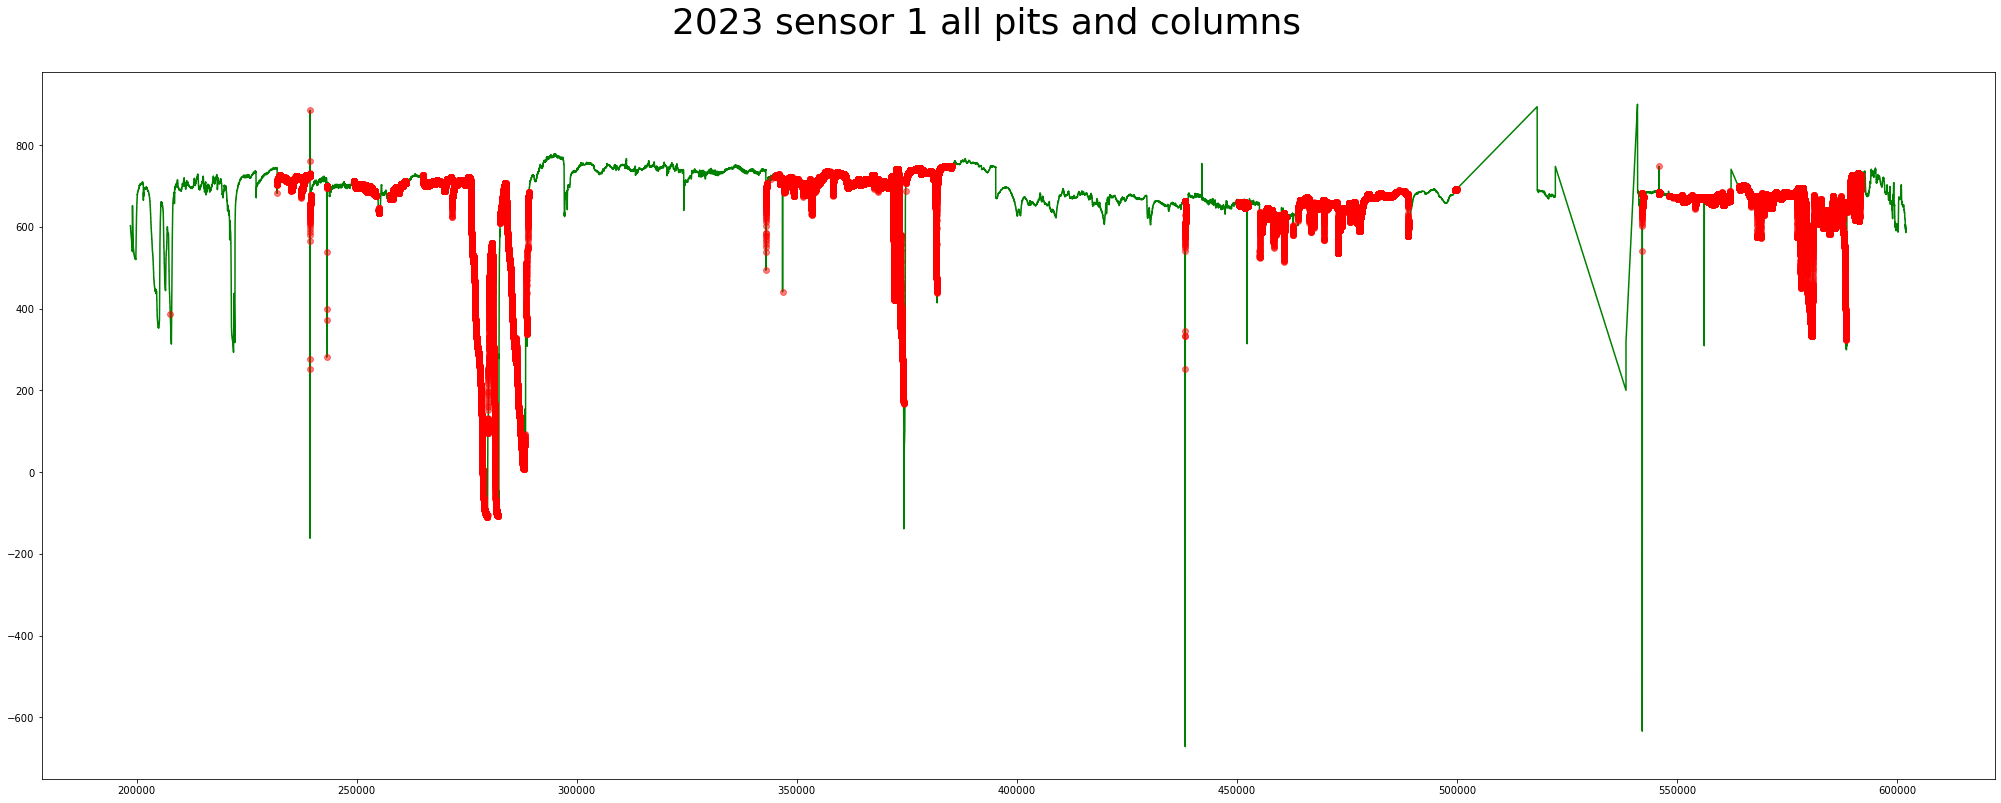

In [13]:
testing_data_X = sensor_data[f'sensor_{1}']['X_test']
testing_data_y = sensor_data[f'sensor_{1}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{1}']['test_2023']

sensor_results_2022 = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{1}_2022'], 1)
sensor_results_2023 = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{1}_2023'])

plot_confusion_matrix(sensor_cm[f'sensor_{1}_2022'])
plot_sensor_results(sensor_results_2022, 1, f'2022 sensor {1} all pits and columns')
plot_2023_sensor_results(sensor_results_2023, 1, f'2023 sensor {1} all pits and columns')

## Sensor 2

False positive (cyan) count:  21
False negative (orange) count:  8


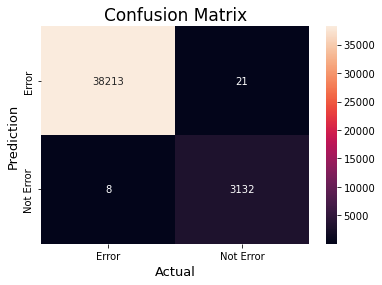

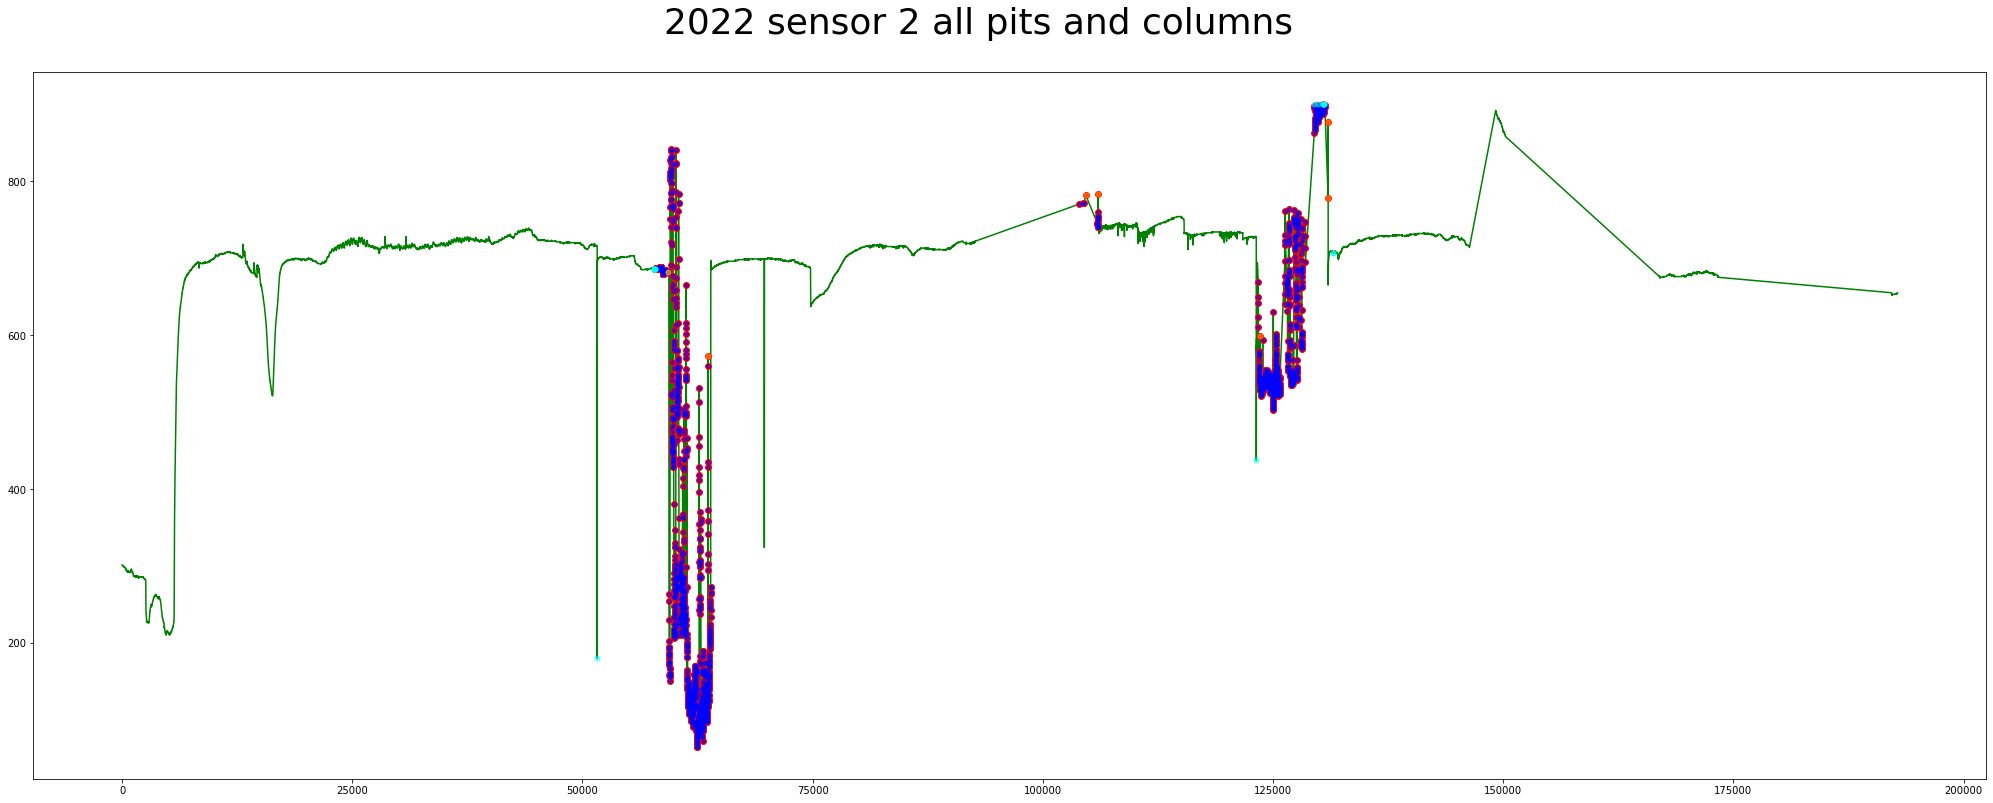

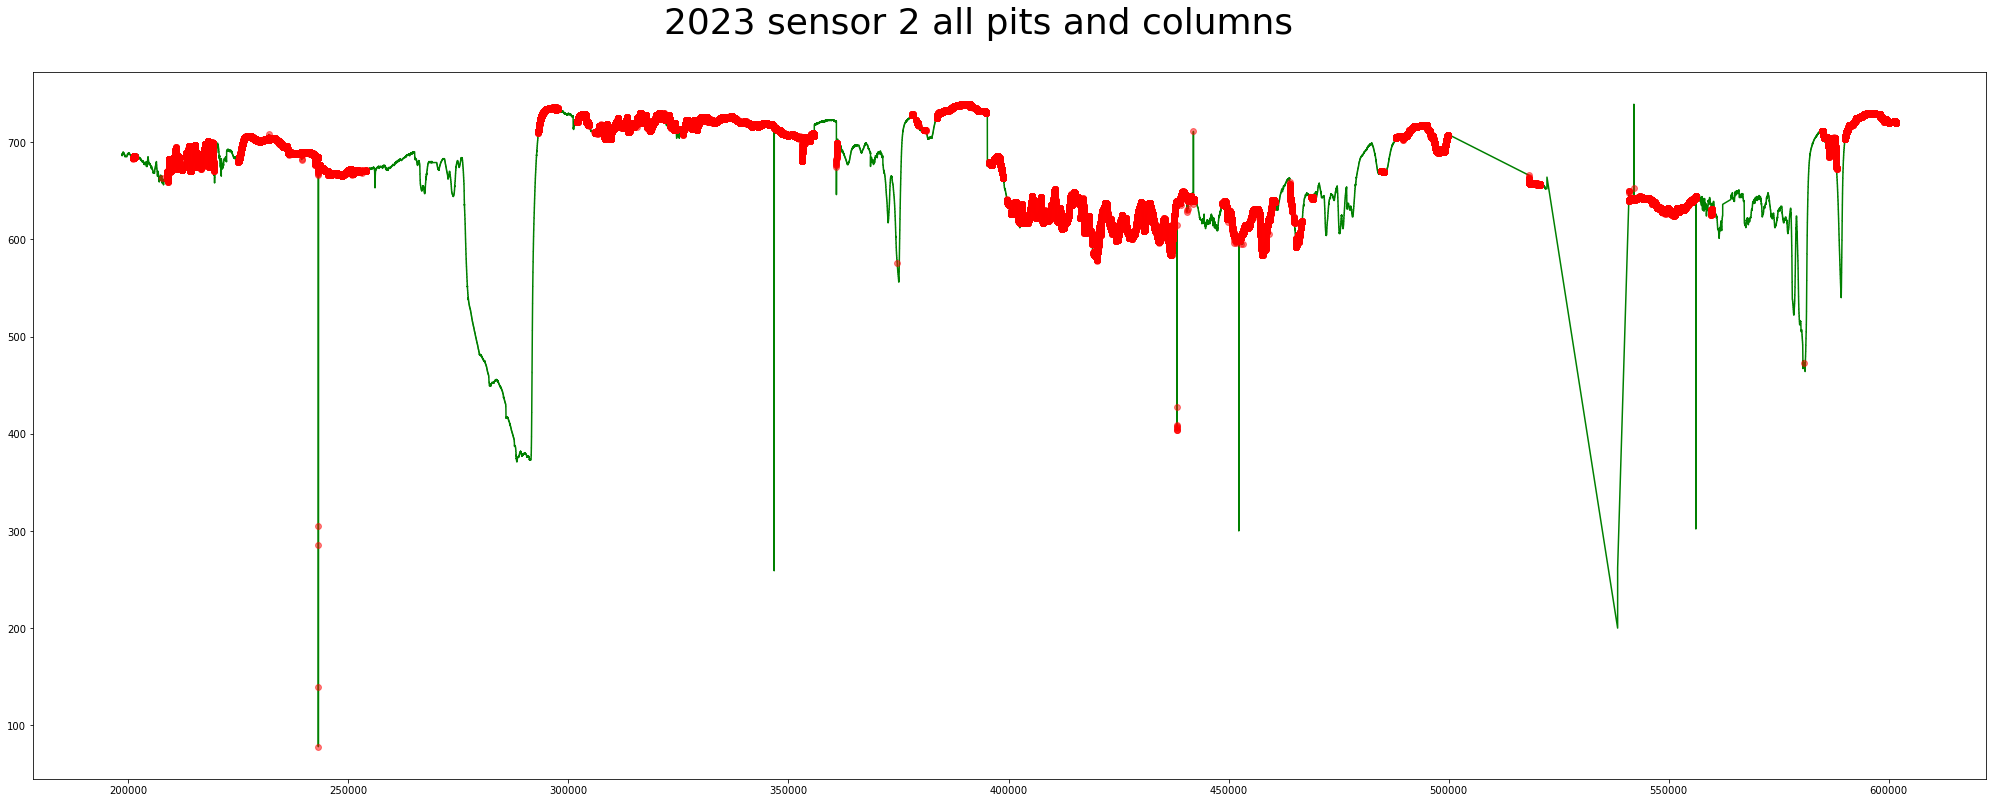

In [14]:
testing_data_X = sensor_data[f'sensor_{2}']['X_test']
testing_data_y = sensor_data[f'sensor_{2}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{2}']['test_2023']

sensor_results_2022 = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{2}_2022'], 2)
sensor_results_2023 = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{2}_2023'])

plot_confusion_matrix(sensor_cm[f'sensor_{2}_2022'])
plot_sensor_results(sensor_results_2022, 2, f'2022 sensor {2} all pits and columns')
plot_2023_sensor_results(sensor_results_2023, 2, f'2023 sensor {2} all pits and columns')

## Sensor 3

False positive (cyan) count:  2523
False negative (orange) count:  0


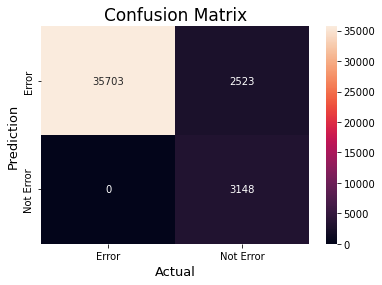

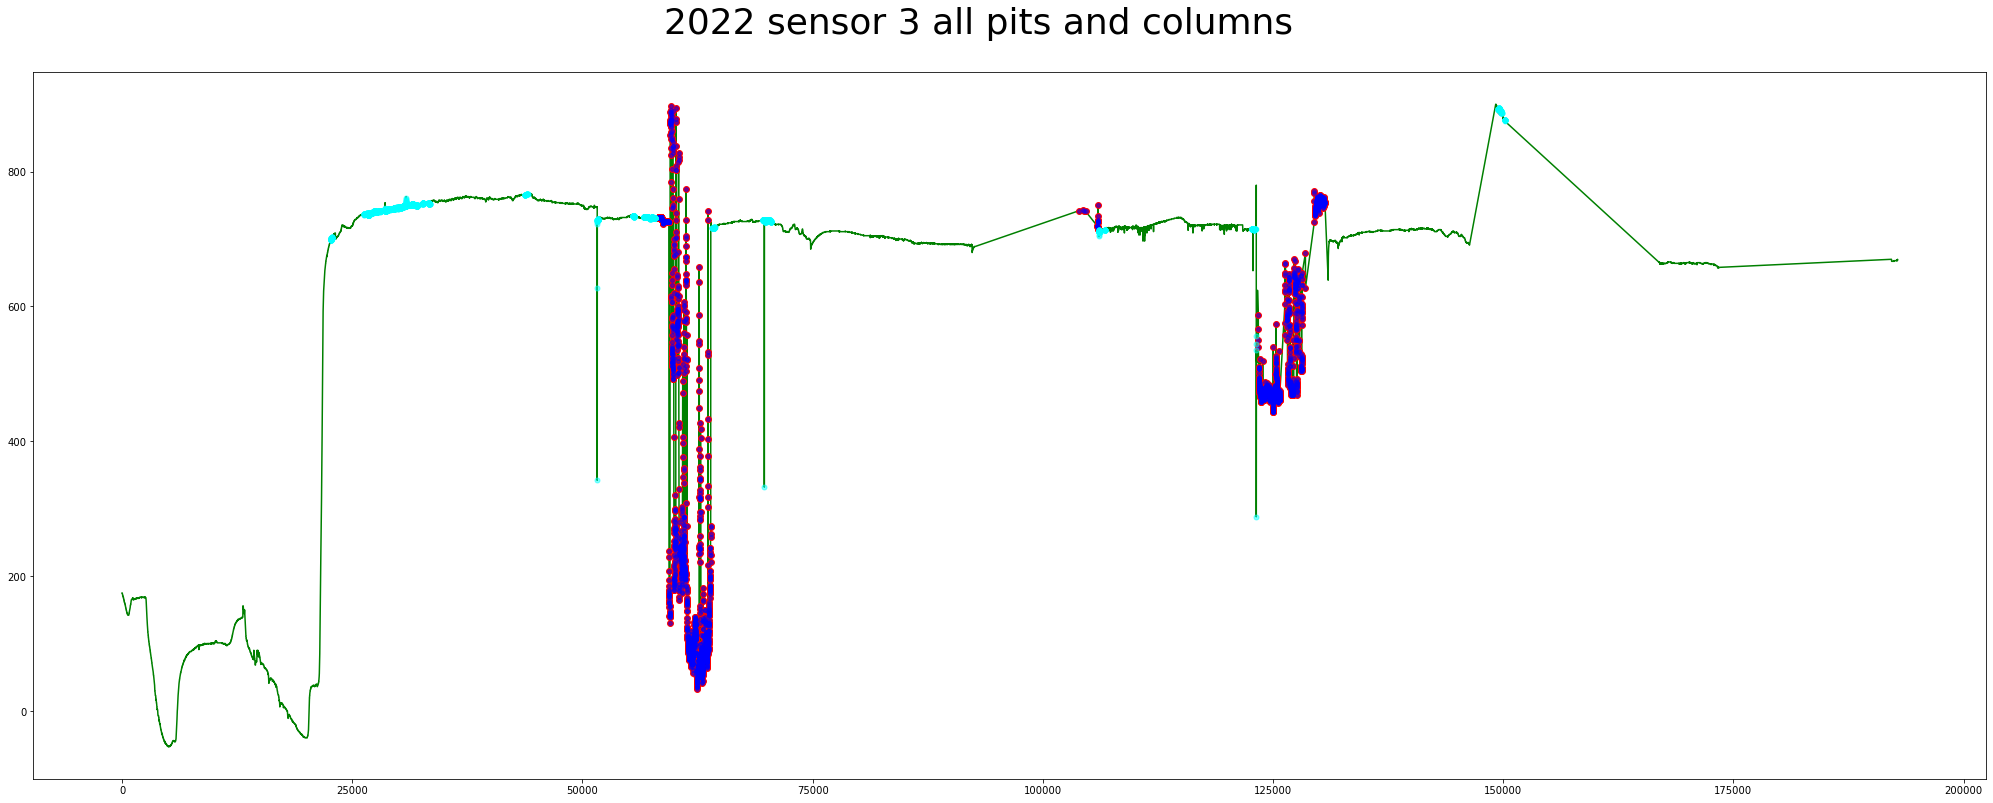

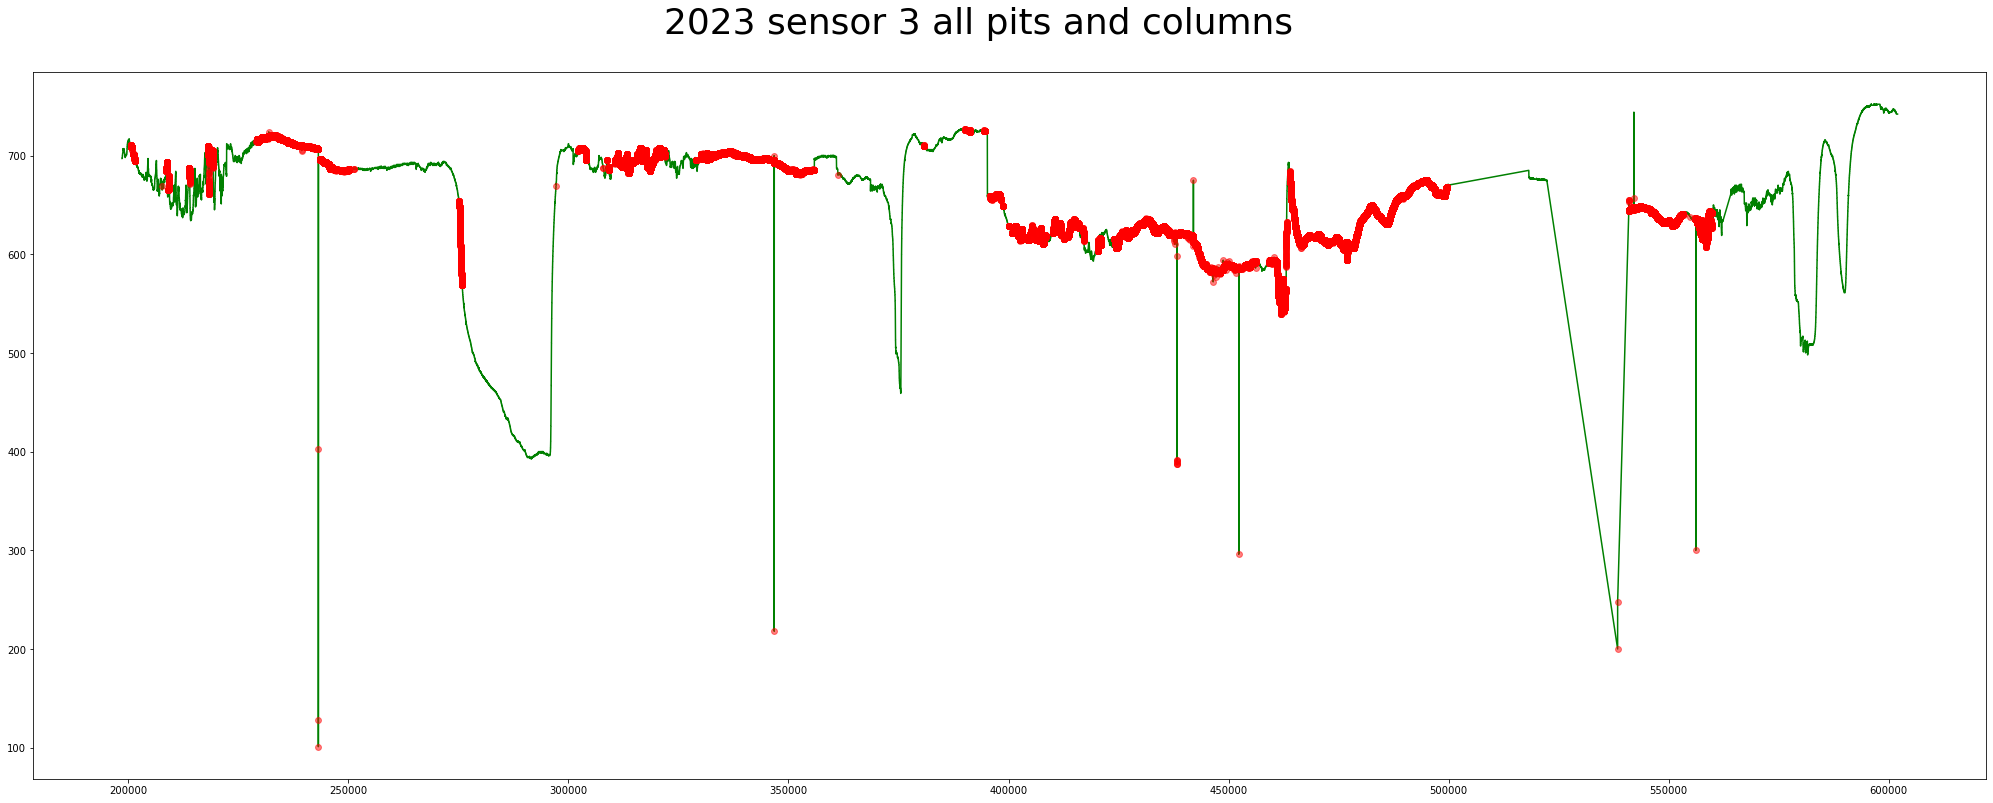

In [15]:
testing_data_X = sensor_data[f'sensor_{3}']['X_test']
testing_data_y = sensor_data[f'sensor_{3}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{3}']['test_2023']

sensor_results_2022 = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{3}_2022'], 3)
sensor_results_2023 = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{3}_2023'])

plot_confusion_matrix(sensor_cm[f'sensor_{3}_2022'])
plot_sensor_results(sensor_results_2022, 3, f'2022 sensor {3} all pits and columns')
plot_2023_sensor_results(sensor_results_2023, 3, f'2023 sensor {3} all pits and columns')

## Sensor 4

False positive (cyan) count:  1
False negative (orange) count:  1008


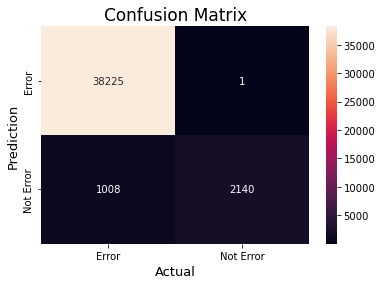

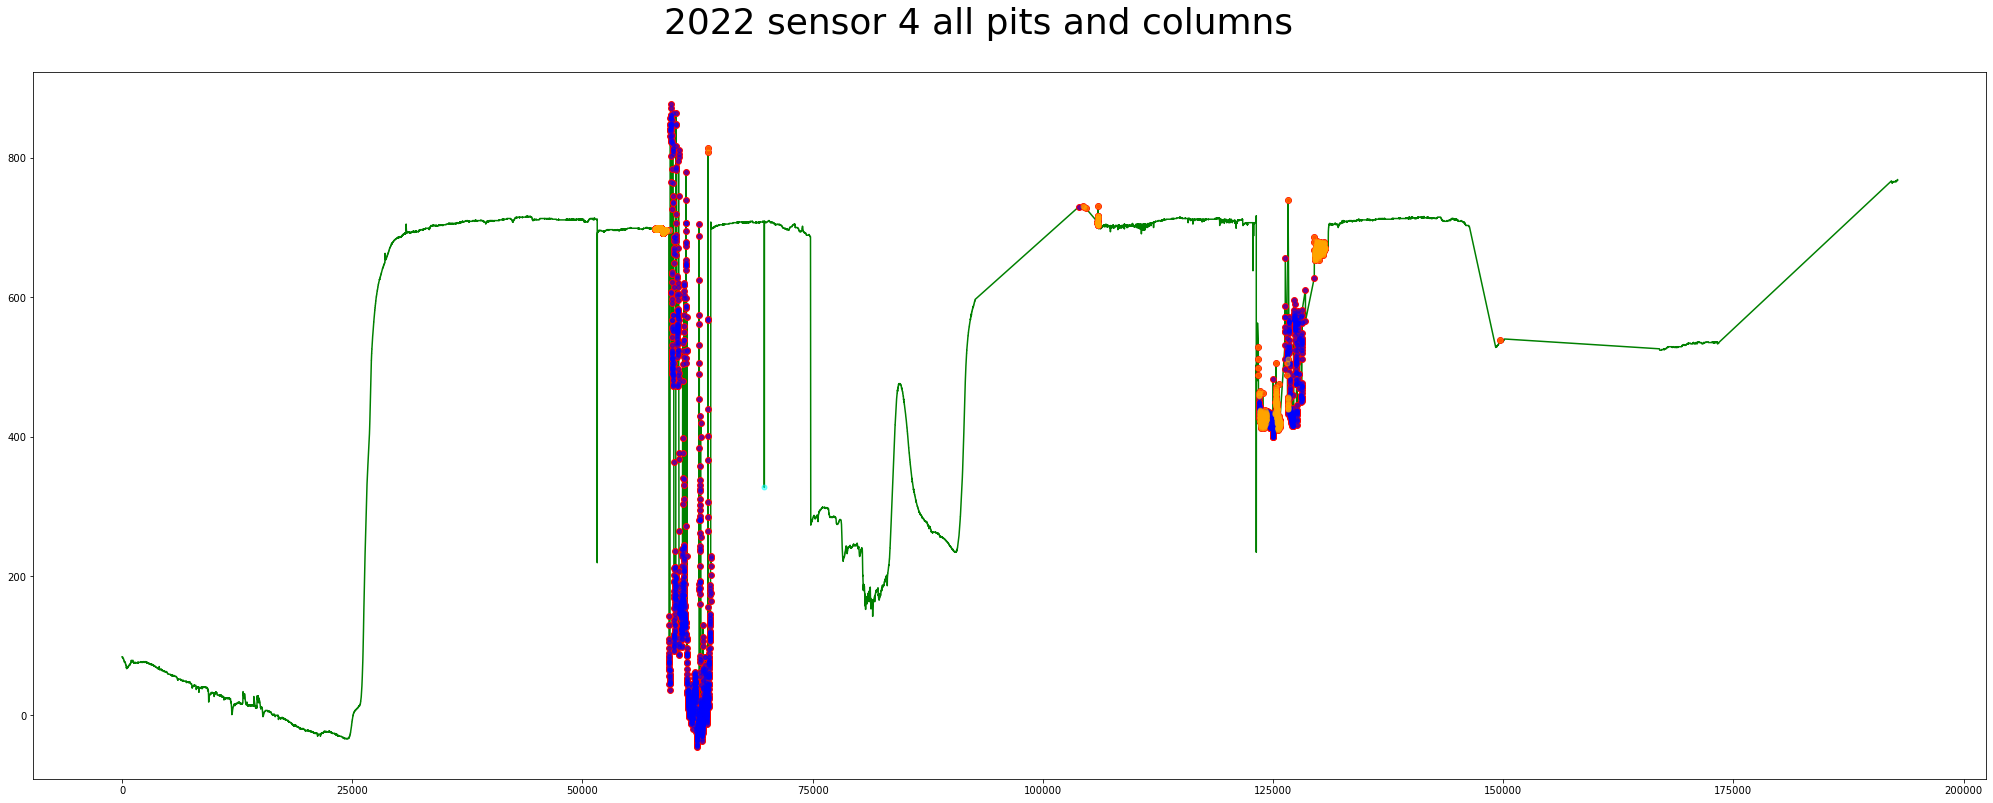

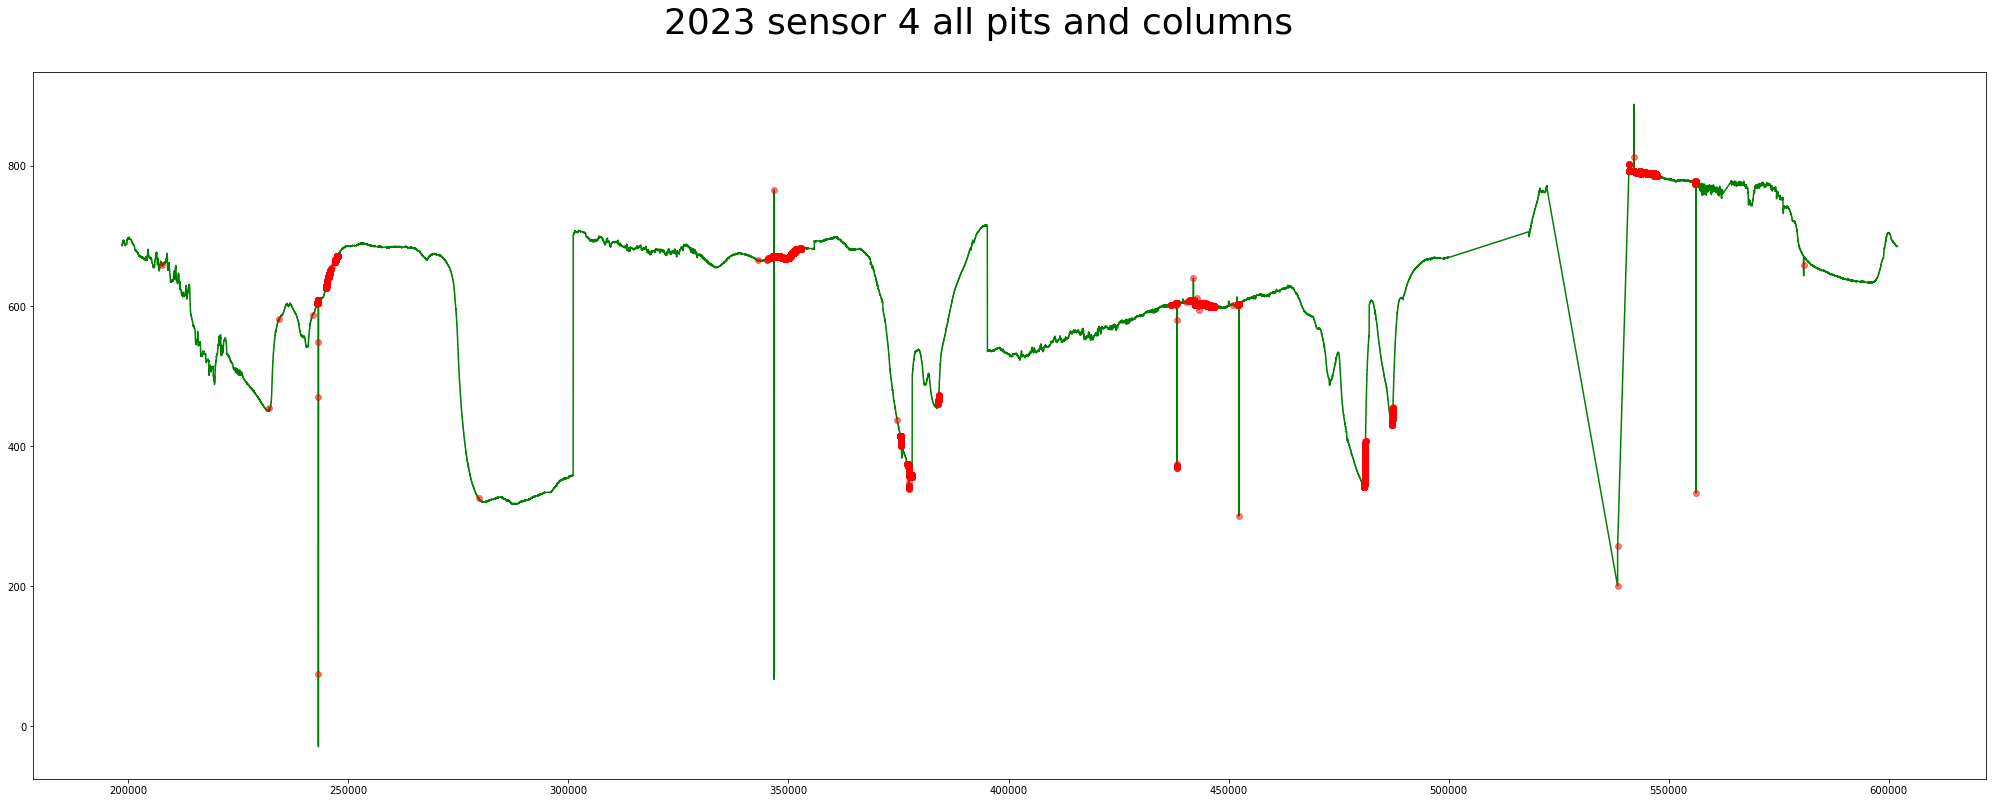

In [16]:
testing_data_X = sensor_data[f'sensor_{4}']['X_test']
testing_data_y = sensor_data[f'sensor_{4}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{4}']['test_2023']

sensor_results_2022 = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{4}_2022'], 4)
sensor_results_2023 = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{4}_2023'])

plot_confusion_matrix(sensor_cm[f'sensor_{4}_2022'])
plot_sensor_results(sensor_results_2022, 4, f'2022 sensor {4} all pits and columns')
plot_2023_sensor_results(sensor_results_2023, 4, f'2023 sensor {4} all pits and columns')

## Sensor 5

False positive (cyan) count:  32
False negative (orange) count:  100


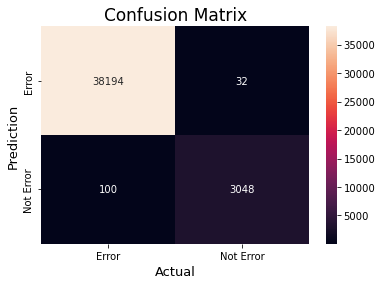

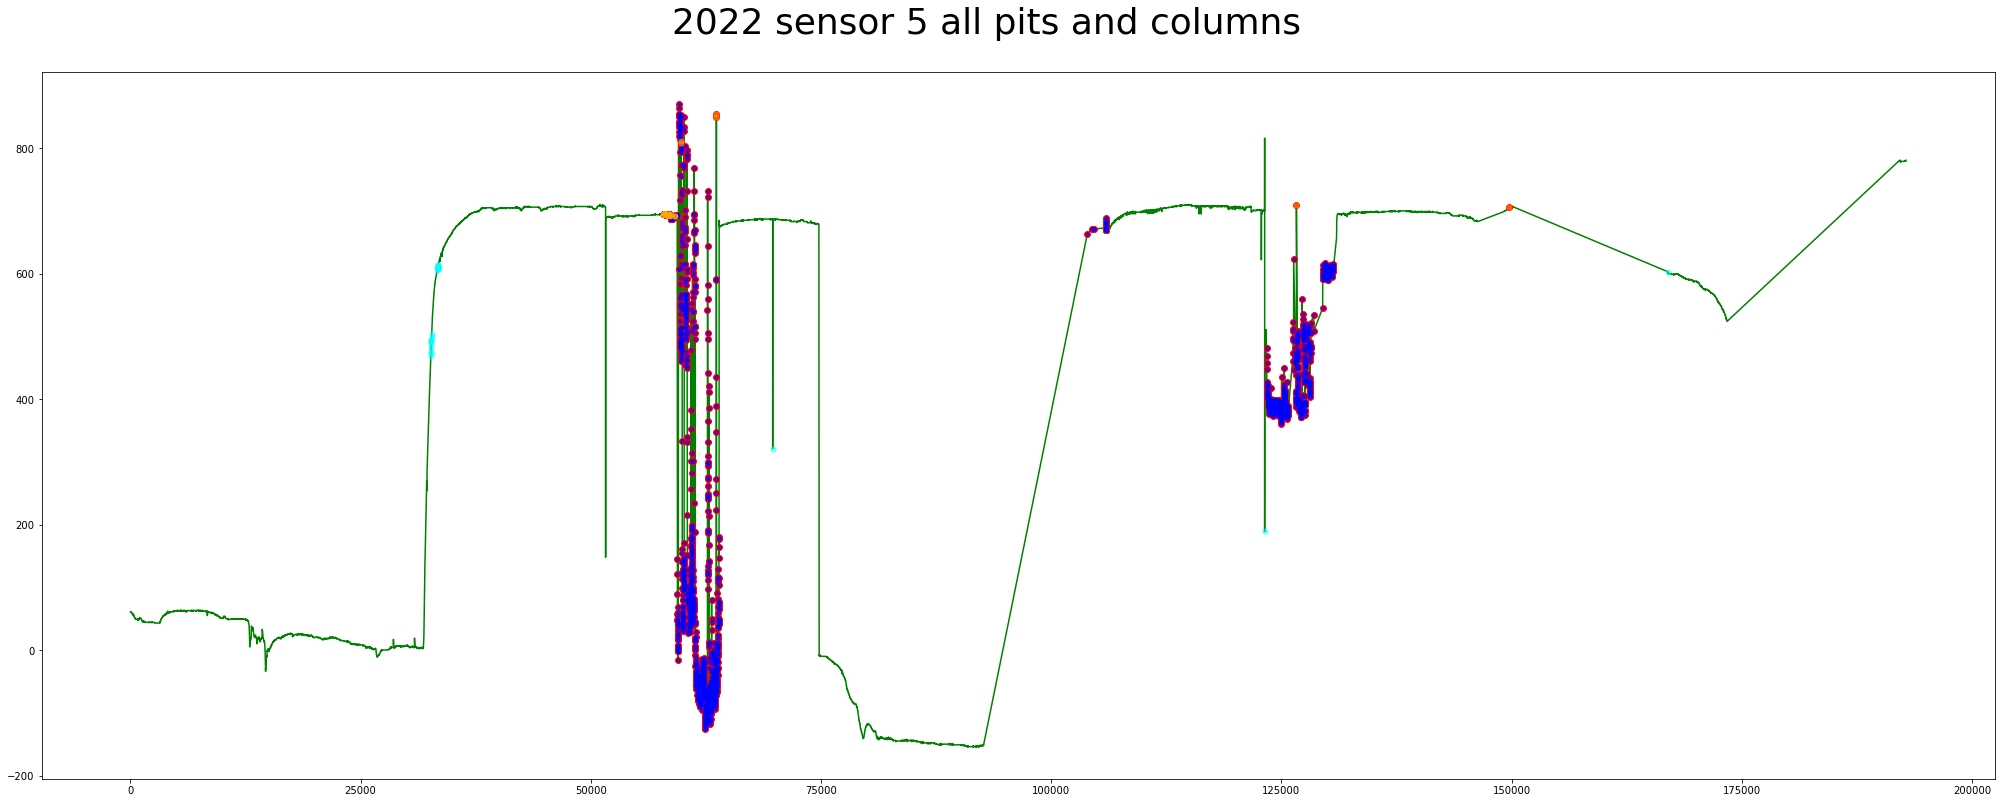

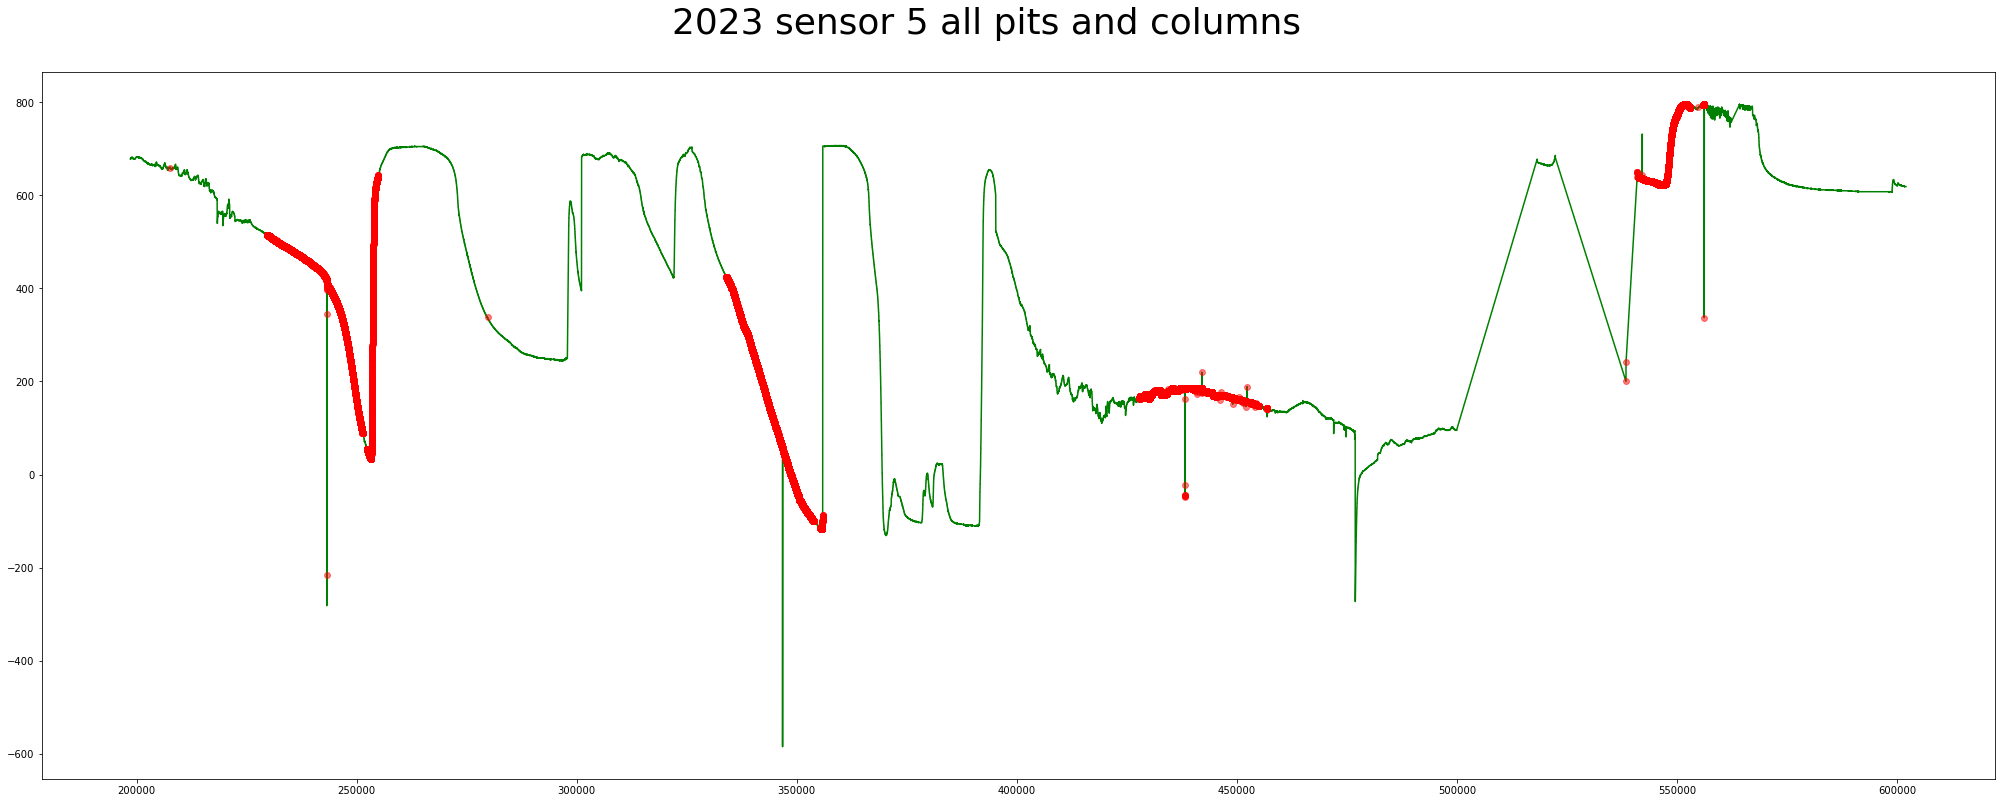

In [17]:
testing_data_X = sensor_data[f'sensor_{5}']['X_test']
testing_data_y = sensor_data[f'sensor_{5}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{5}']['test_2023']

sensor_results_2022 = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{5}_2022'], 5)
sensor_results_2023 = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{5}_2023'])

plot_confusion_matrix(sensor_cm[f'sensor_{5}_2022'])
plot_sensor_results(sensor_results_2022, 5, f'2022 sensor {5} all pits and columns')
plot_2023_sensor_results(sensor_results_2023, 5, f'2023 sensor {5} all pits and columns')

## 2022 sensor feature selection columns

## Sensor 1

False positive (cyan) count:  26
False negative (orange) count:  563


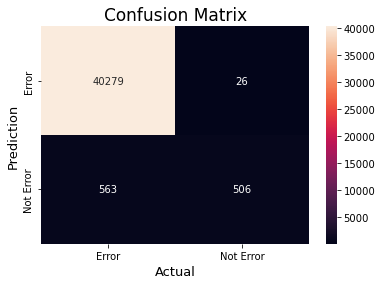

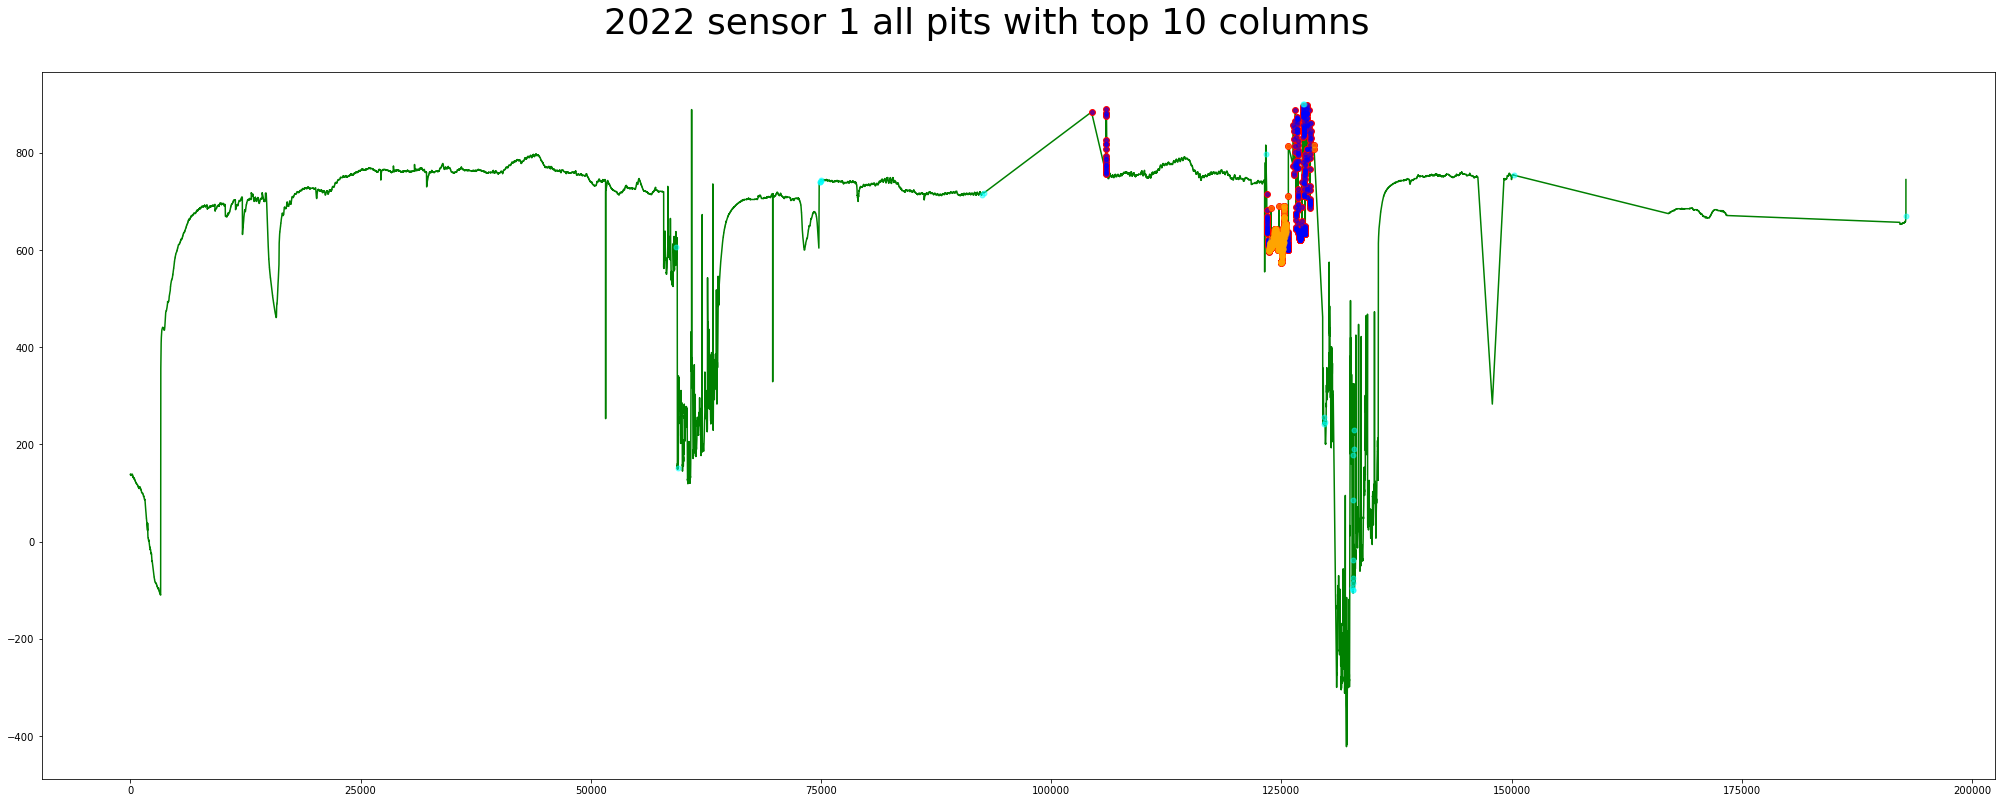

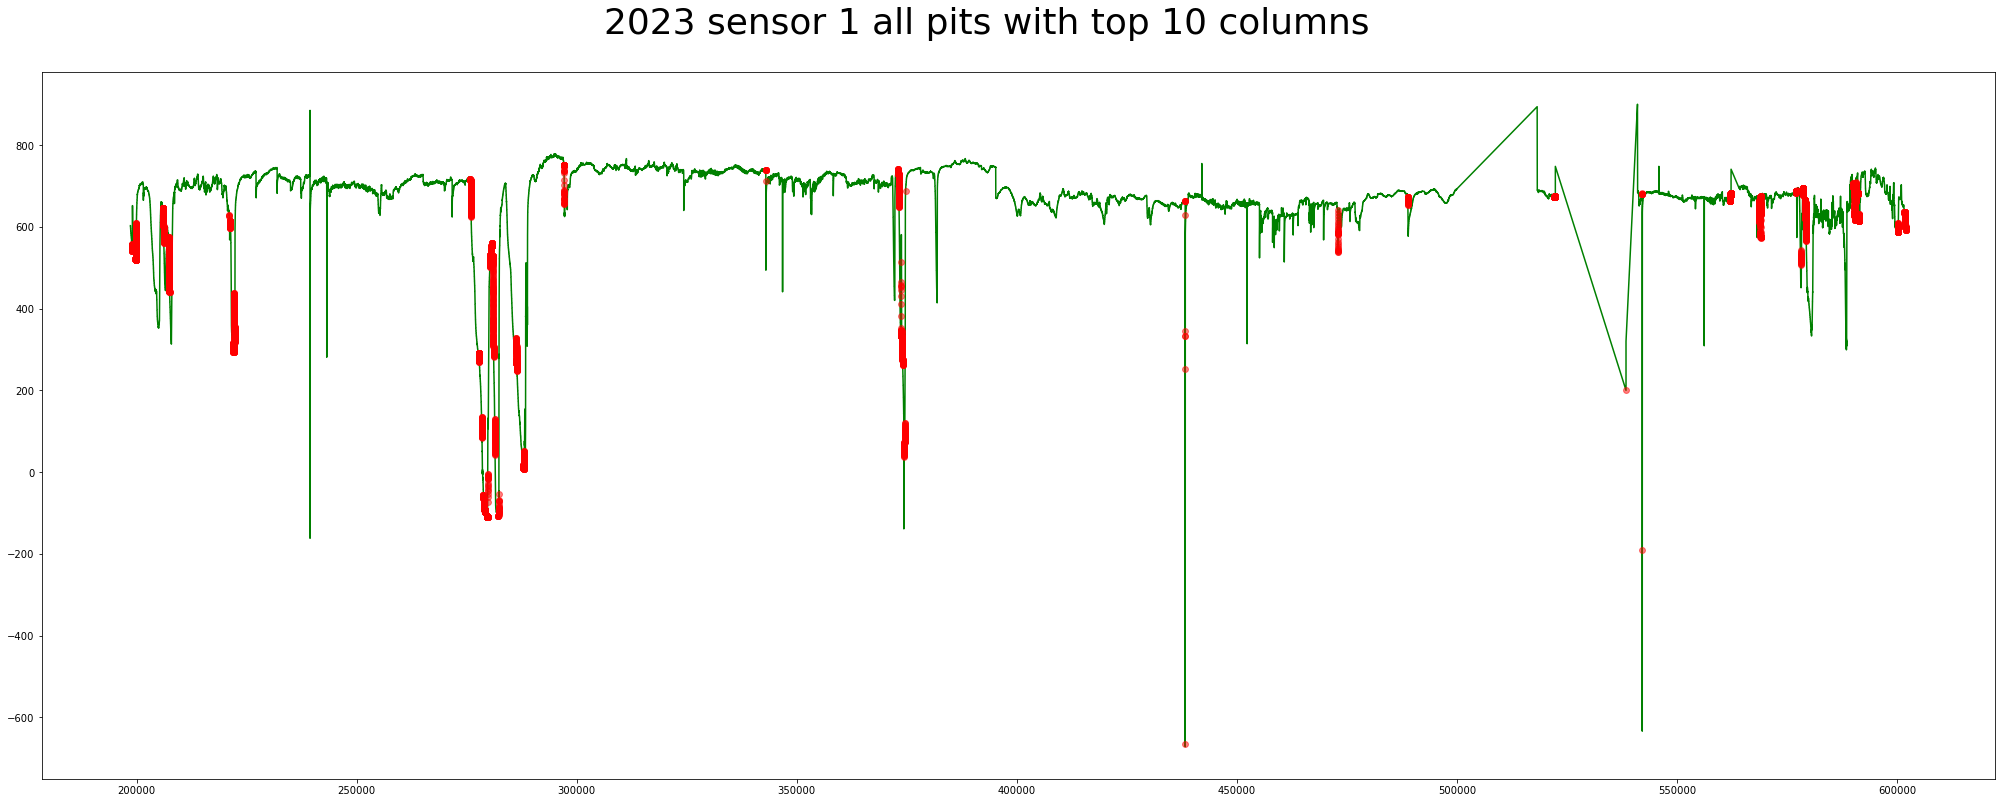

In [18]:
testing_data_X = sensor_data[f'sensor_{1}']['X_test']
testing_data_y = sensor_data[f'sensor_{1}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{1}']['test_2023']

sensor_results_2022_fs = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{1}_2022_fs'], 1)
sensor_results_2023_fs = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{1}_2023_fs'])

plot_confusion_matrix(sensor_cm[f'sensor_{1}_2022_fs'])
plot_sensor_results(sensor_results_2022_fs, 1, f'2022 sensor {1} all pits with top 10 columns')
plot_2023_sensor_results(sensor_results_2023_fs, 1, f'2023 sensor {1} all pits with top 10 columns')

## Sensor 2

False positive (cyan) count:  17
False negative (orange) count:  1352


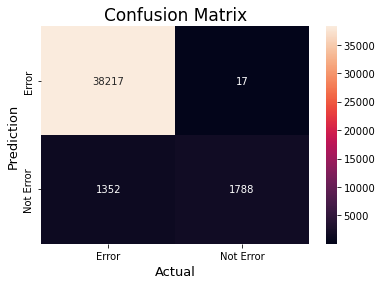

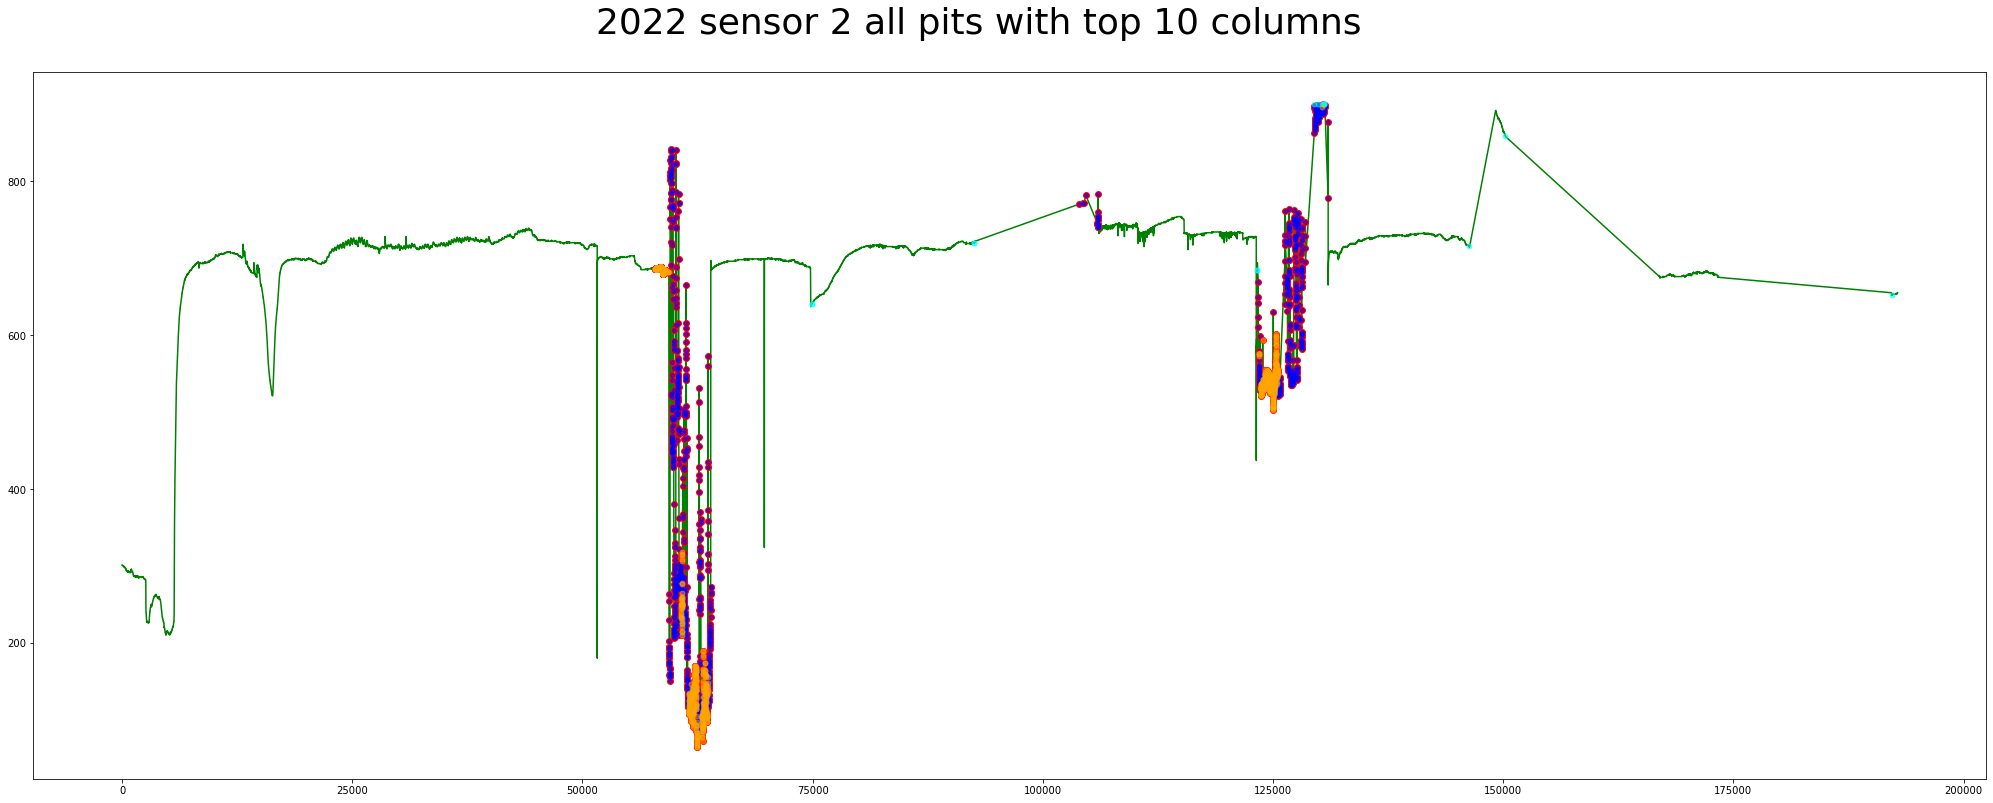

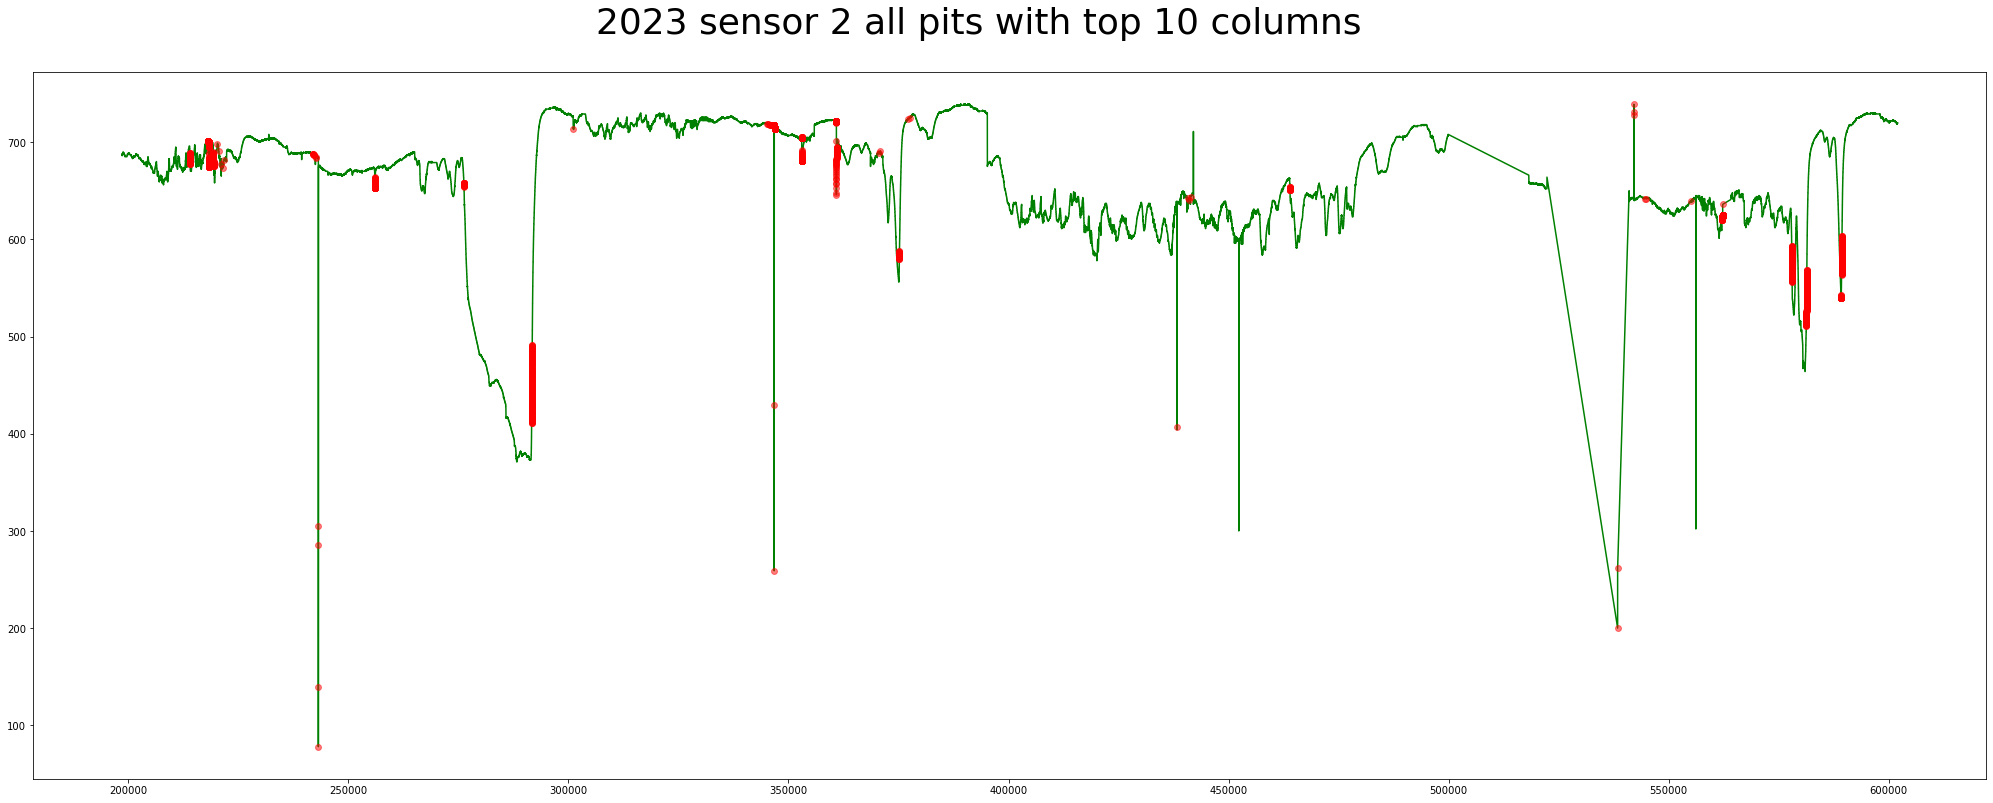

In [19]:
testing_data_X = sensor_data[f'sensor_{2}']['X_test']
testing_data_y = sensor_data[f'sensor_{2}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{2}']['test_2023']

sensor_results_2022_fs = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{2}_2022_fs'], 2)
sensor_results_2023_fs = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{2}_2023_fs'])

plot_confusion_matrix(sensor_cm[f'sensor_{2}_2022_fs'])
plot_sensor_results(sensor_results_2022_fs, 2, f'2022 sensor {2} all pits with top 10 columns')
plot_2023_sensor_results(sensor_results_2023_fs, 2, f'2023 sensor {2} all pits with top 10 columns')

## Sensor 3

False positive (cyan) count:  40
False negative (orange) count:  1349


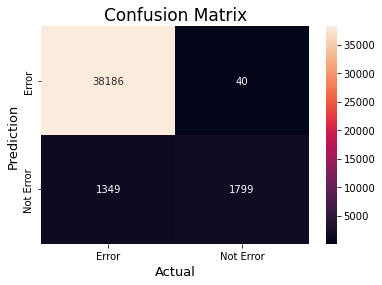

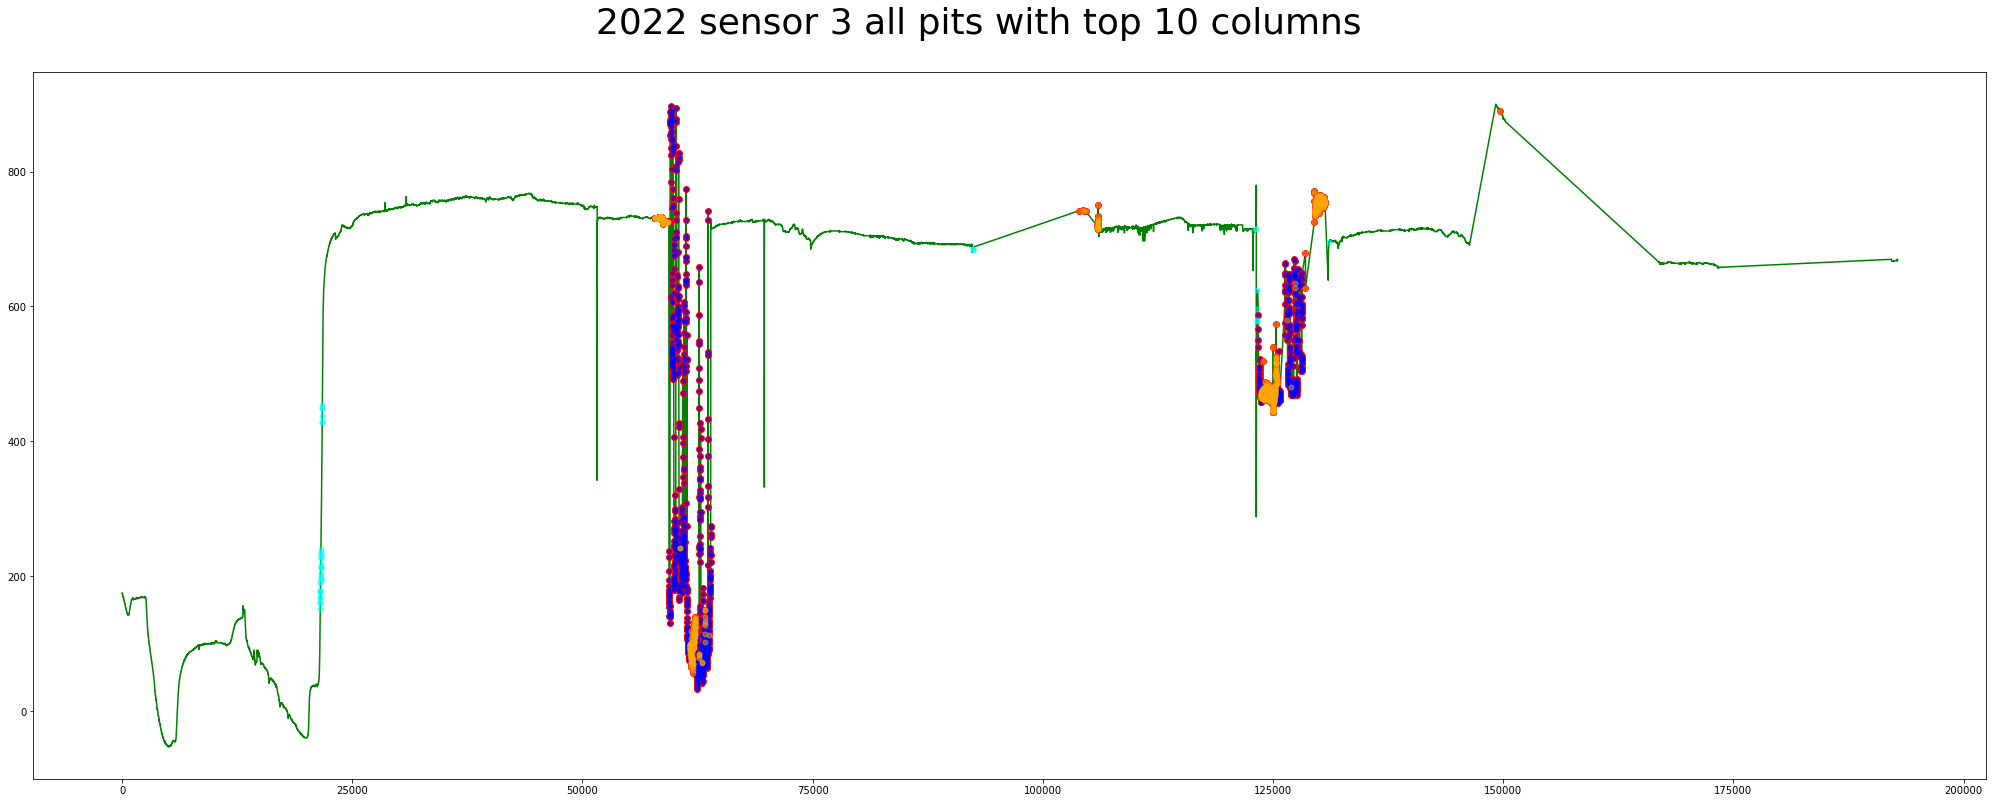

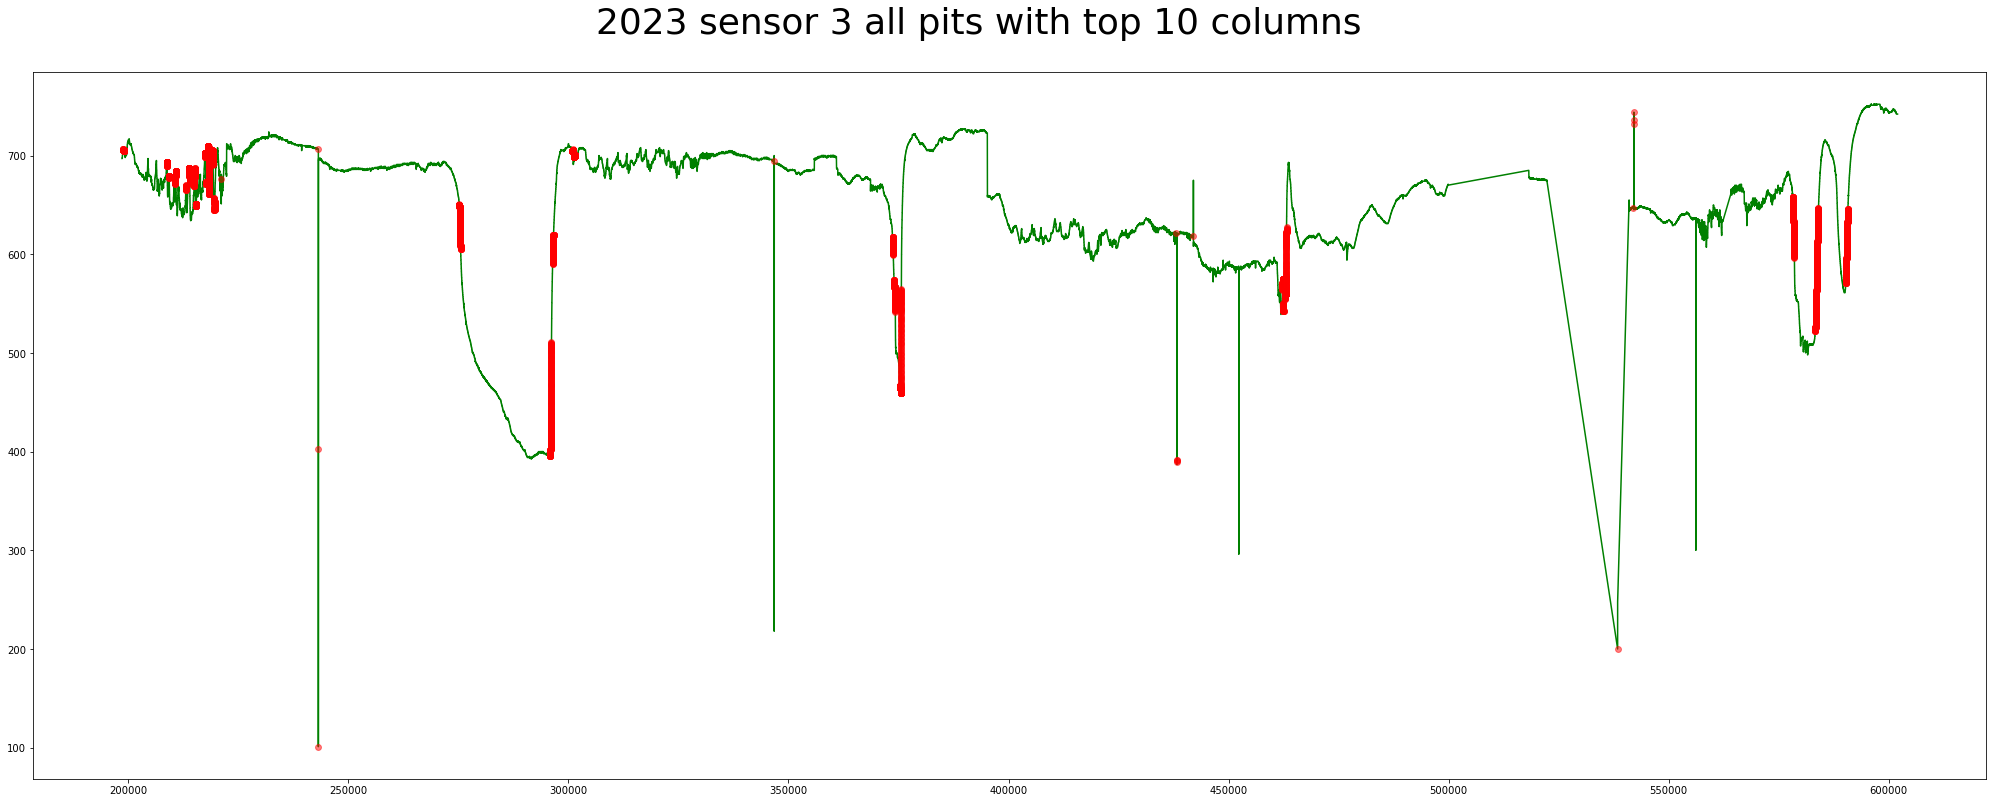

In [20]:
testing_data_X = sensor_data[f'sensor_{3}']['X_test']
testing_data_y = sensor_data[f'sensor_{3}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{3}']['test_2023']

sensor_results_2022_fs = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{3}_2022_fs'], 3)
sensor_results_2023_fs = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{3}_2023_fs'])

plot_confusion_matrix(sensor_cm[f'sensor_{3}_2022_fs'])
plot_sensor_results(sensor_results_2022_fs, 3, f'2022 sensor {3} all pits with top 10 columns')
plot_2023_sensor_results(sensor_results_2023_fs, 3, f'2023 sensor {3} all pits with top 10 columns')

## Sensor 4

False positive (cyan) count:  4
False negative (orange) count:  1248


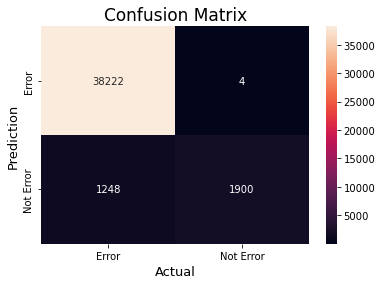

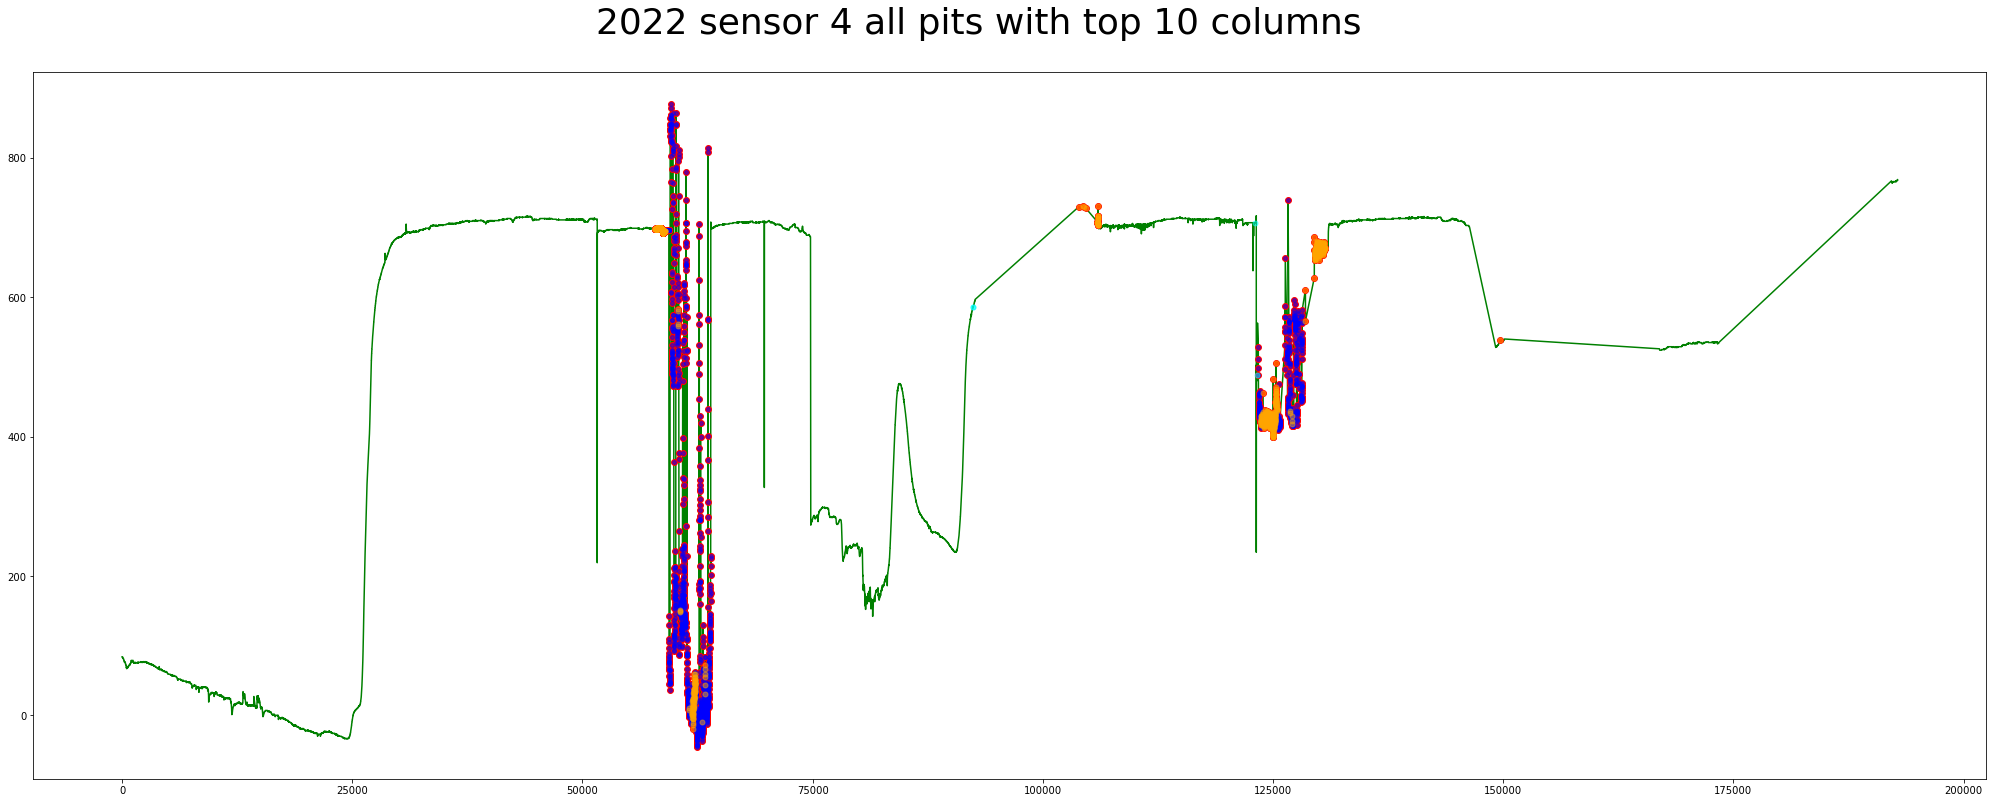

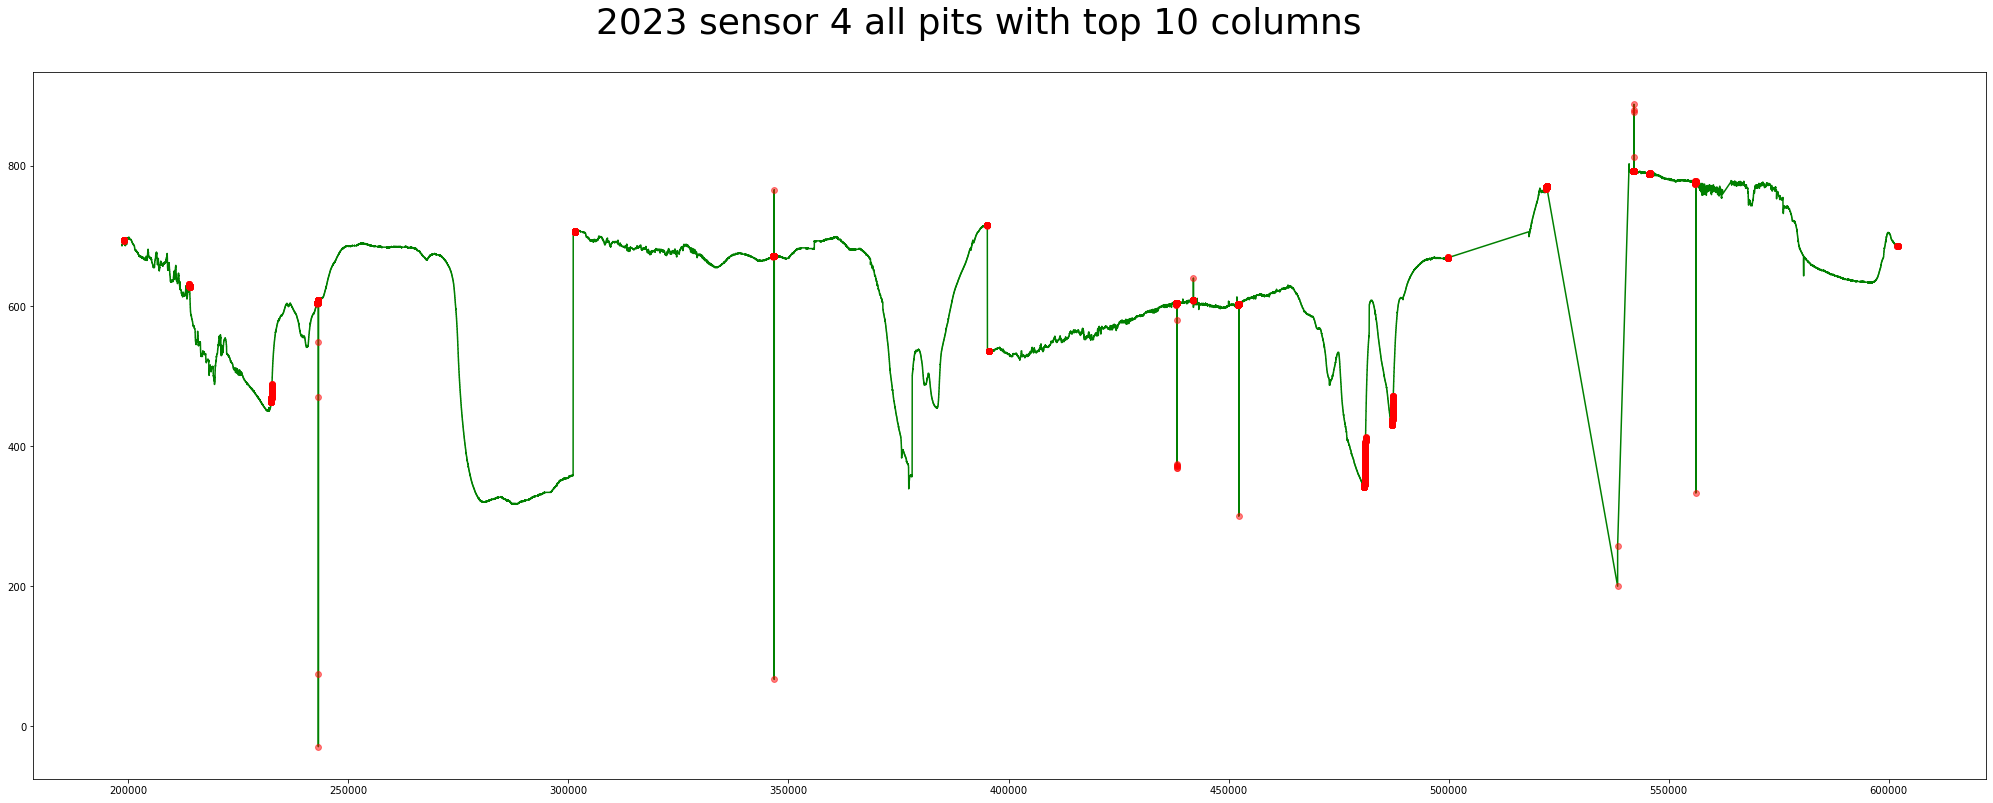

In [21]:
testing_data_X = sensor_data[f'sensor_{4}']['X_test']
testing_data_y = sensor_data[f'sensor_{4}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{4}']['test_2023']

sensor_results_2022_fs = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{4}_2022_fs'], 4)
sensor_results_2023_fs = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{4}_2023_fs'])

plot_confusion_matrix(sensor_cm[f'sensor_{4}_2022_fs'])
plot_sensor_results(sensor_results_2022_fs, 4, f'2022 sensor {4} all pits with top 10 columns')
plot_2023_sensor_results(sensor_results_2023_fs, 4, f'2023 sensor {4} all pits with top 10 columns')

## Sensor 5

False positive (cyan) count:  13
False negative (orange) count:  1219


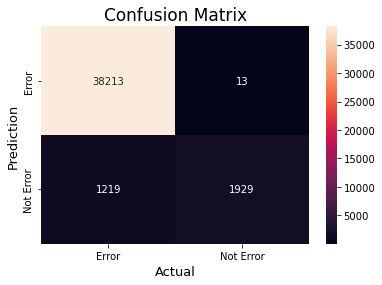

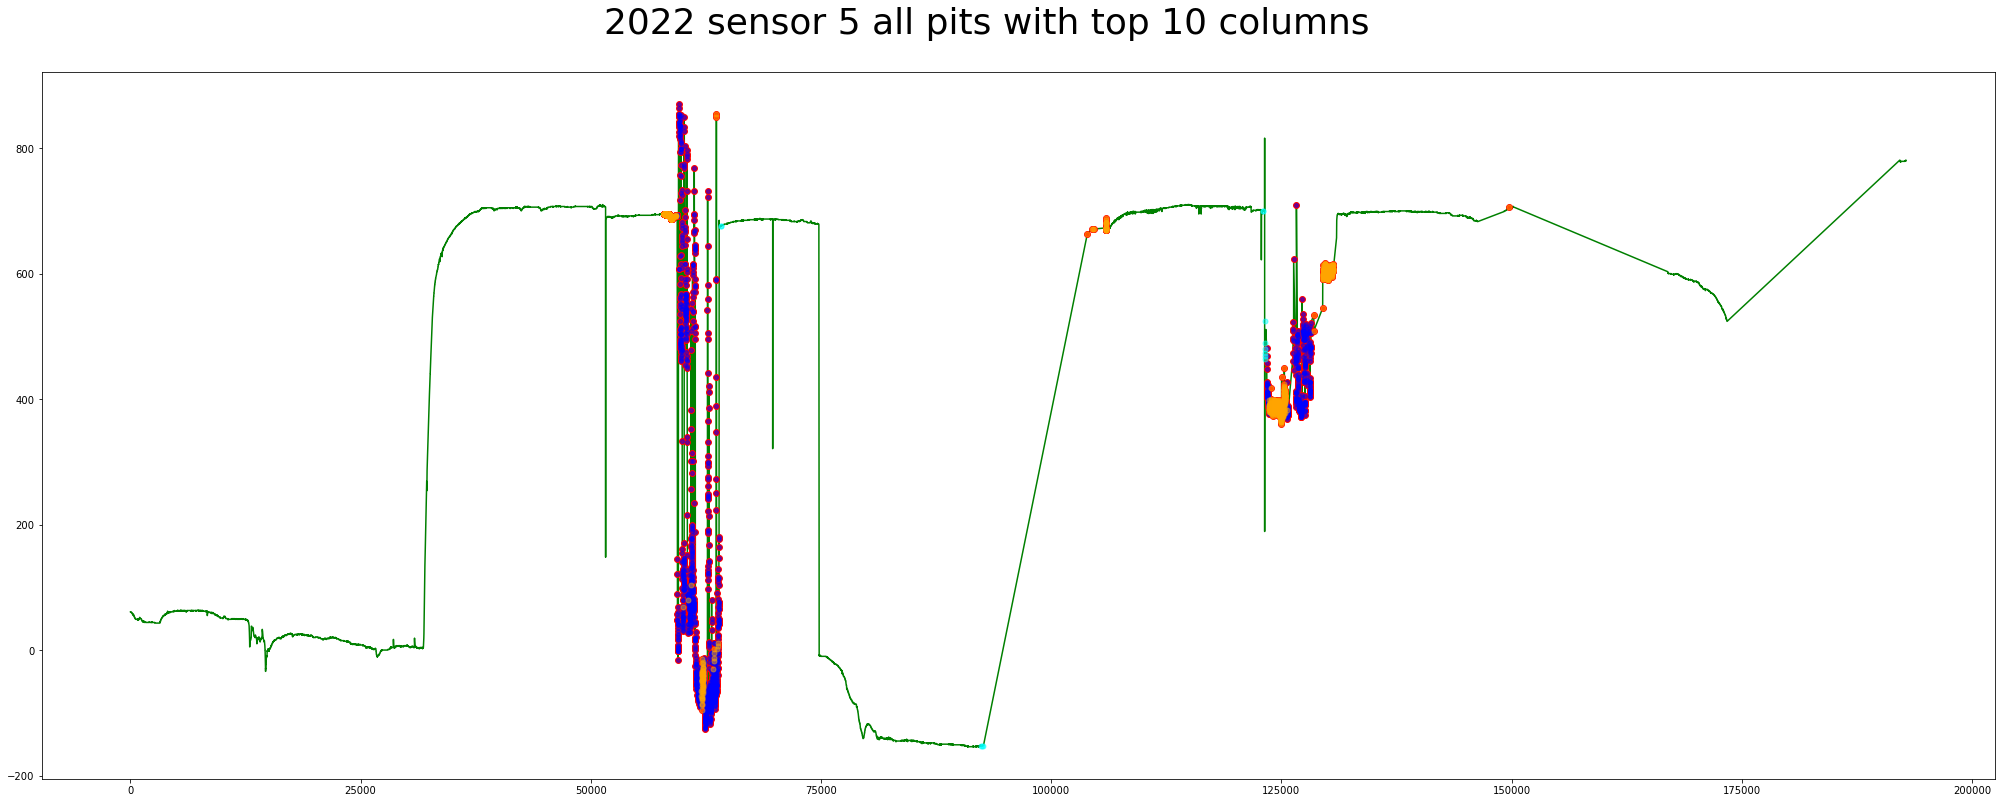

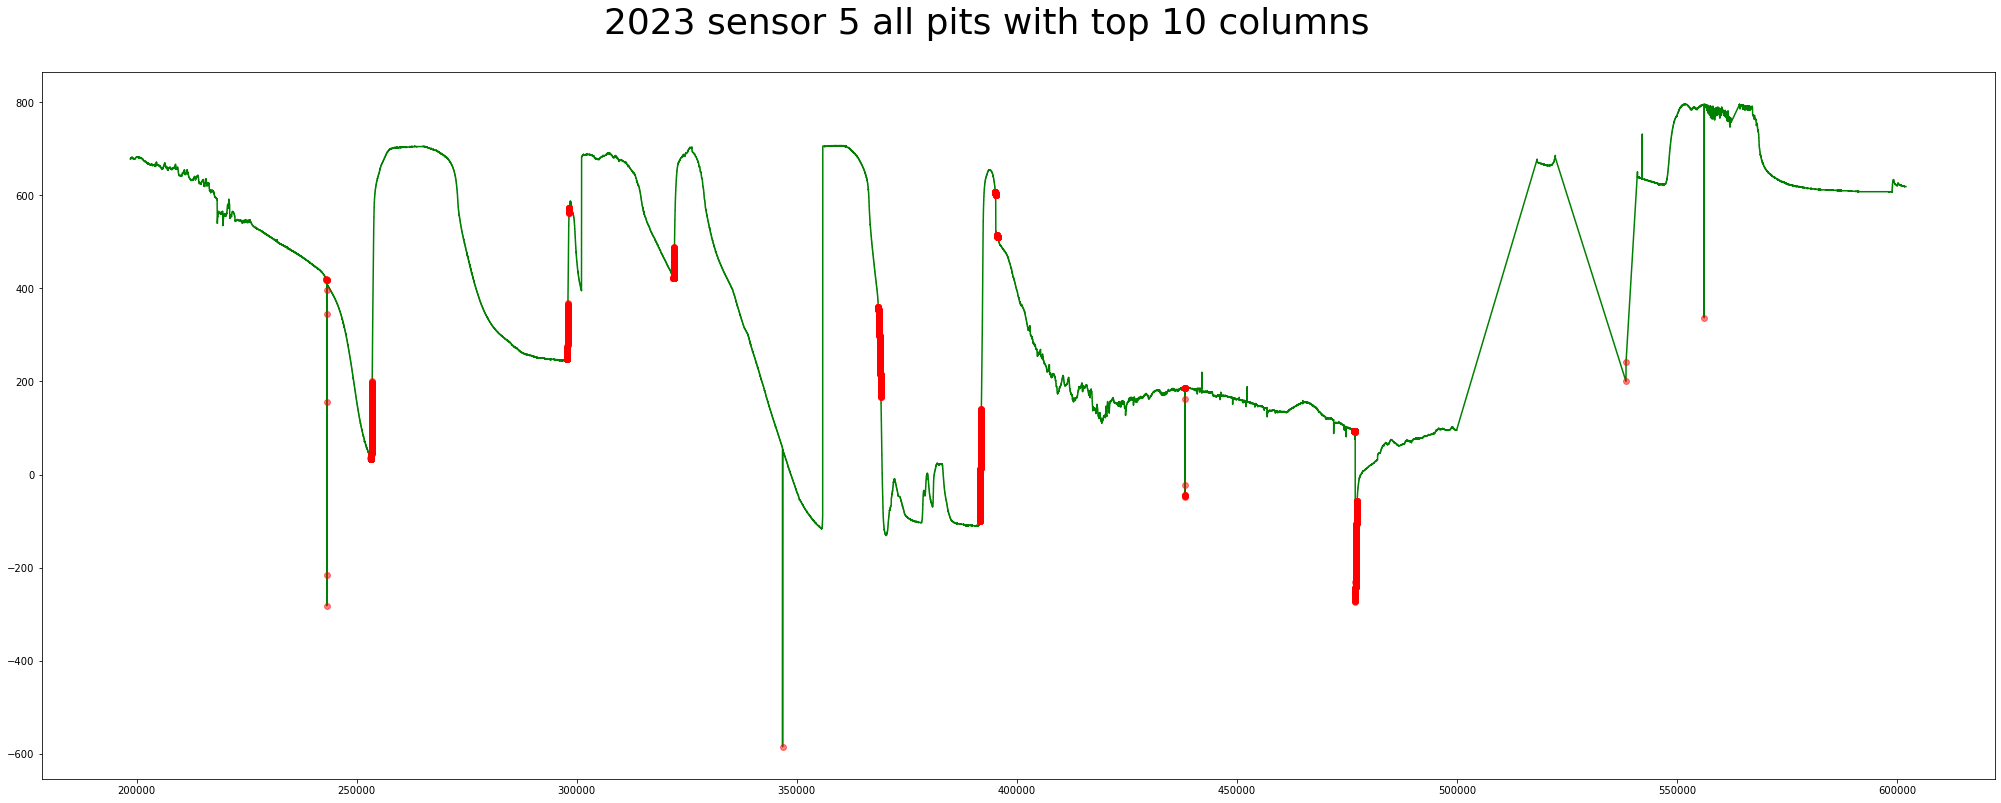

In [22]:
testing_data_X = sensor_data[f'sensor_{5}']['X_test']
testing_data_y = sensor_data[f'sensor_{5}']['y_test']
testing_data_2023 = sensor_data[f'sensor_{5}']['test_2023']

sensor_results_2022_fs = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{5}_2022_fs'], 5)
sensor_results_2023_fs = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{5}_2023_fs'])

plot_confusion_matrix(sensor_cm[f'sensor_{5}_2022_fs'])
plot_sensor_results(sensor_results_2022_fs, 5, f'2022 sensor {5} all pits with top 10 columns')
plot_2023_sensor_results(sensor_results_2023_fs, 5, f'2023 sensor {5} all pits with top 10 columns')

## 2022 sensor wavelet columns

In [23]:
# for sensor in sensors:
#     testing_data_X = sensor_data[f'sensor_{sensor}']['X_test']
#     testing_data_y = sensor_data[f'sensor_{sensor}']['y_test']
#     testing_data_2023 = sensor_data[f'sensor_{sensor}']['test_2023']

#     sensor_results_2022_wavelet = get_results_df(testing_data_X, testing_data_y, sensor_predictions[f'sensor_{sensor}_2022_wavelet'], sensor)
#     sensor_results_2023_wavelet = get_results_df_2023(testing_data_2023, sensor_predictions[f'sensor_{sensor}_2023_wavelet'], sensor)

#     plot_confusion_matrix(sensor_cm[f'sensor_{sensor}_2022_wavelet'])
#     plot_sensor_results(sensor_results_2022_wavelet, sensor, f'2022 sensor {sensor} all pits with wavelet columns')
#     plot_2023_sensor_results(sensor_results_2023_wavelet, sensor, f'2023 sensor {sensor} all pits with wavelet columns')